# Installs & Imports

In [1]:
# Install packages
# !pip install pandas numpy matplotlib seaborn scipy scikit-learn shap openpyxl


In [2]:
# Standard library
import os
import copy
import pickle
import json
from pathlib import Path
from datetime import datetime

# Core data & viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Stats 
from scipy import stats

# Scikit-learn 
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    ElasticNet, ElasticNetCV, Lasso, LassoCV, LinearRegression, Ridge, RidgeCV
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, learning_curve
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer, StandardScaler


# Utility Functions

In [3]:
def huber_loss(y_true, y_pred, delta=1.0):
    """Calculate Huber loss manually for comparison"""
    error = y_true - y_pred
    is_small = np.abs(error) <= delta
    loss = np.where(is_small, 0.5 * error**2, delta * (np.abs(error) - 0.5 * delta))
    return np.mean(loss)


def calculate_all_metrics(y_true, y_pred, prefix=""):
    """Calculate comprehensive regression metrics including regulatory context"""
    metrics = {
        f'{prefix}RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        f'{prefix}MAE': mean_absolute_error(y_true, y_pred),
        f'{prefix}R2': r2_score(y_true, y_pred),
        f'{prefix}Huber': huber_loss(y_true, y_pred),
        f'{prefix}MSE': mean_squared_error(y_true, y_pred)
    }
    
    # Add regulatory classification metrics for Quote predictions
    if isinstance(y_true, (pd.Series, np.ndarray)):
        # Regulatory threshold classification accuracy
        true_insolvent = (y_true < 0)
        pred_insolvent = (y_pred < 0)
        true_undercap = (y_true < 1)
        pred_undercap = (y_pred < 1)
        true_wellcap = (y_true > 2)
        pred_wellcap = (y_pred > 2)
        
        if len(y_true) > 0:
            metrics[f'{prefix}Insolvent_Accuracy'] = np.mean(true_insolvent == pred_insolvent)
            metrics[f'{prefix}Undercap_Accuracy'] = np.mean(true_undercap == pred_undercap)
            metrics[f'{prefix}WellCap_Accuracy'] = np.mean(true_wellcap == pred_wellcap)
            
            # MAPE for non-zero values (avoid division by zero)
            nonzero_mask = y_true != 0
            if np.sum(nonzero_mask) > 0:
                mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100
                metrics[f'{prefix}MAPE'] = mape
    
    return metrics


In [4]:
def analyze_regulatory_performance(y_true, y_pred, target_name="Quote"):
    """Analyze model performance across regulatory categories"""
    
    # Define regulatory categories
    categories = {
        'Insolvent': y_true < 0,
        'Undercapitalized': (y_true >= 0) & (y_true < 1),
        'Adequate': (y_true >= 1) & (y_true <= 2),
        'Well-Capitalized': y_true > 2
    }
    
    print(f"\nREGULATORY PERFORMANCE ANALYSIS - {target_name}")
    
    results = {}
    for category, mask in categories.items():
        if np.sum(mask) > 0:
            y_true_cat = y_true[mask]
            y_pred_cat = y_pred[mask]
            
            rmse = np.sqrt(mean_squared_error(y_true_cat, y_pred_cat))
            mae = mean_absolute_error(y_true_cat, y_pred_cat)
            r2 = r2_score(y_true_cat, y_pred_cat)
            
            results[category] = {
                'count': np.sum(mask),
                'percentage': np.sum(mask) / len(y_true) * 100,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            }
            
            print(f"\n{category} ({np.sum(mask)} obs, {np.sum(mask)/len(y_true)*100:.1f}%):")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  R²: {r2:.4f}")
    
    return results


In [5]:
def plot_learning_curves(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'):
    """Plot learning curves for model diagnosis"""

    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=8
    )
    
    train_mean = -train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = -val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='red')
    plt.xlabel('Training Set Size')
    plt.ylabel('MSE')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    return plt.gcf()

def plot_residuals(y_true, y_pred, title="Residual Plot"):
    """Create residual plots for model diagnosis"""
    residuals = y_true - y_pred
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Residuals vs Predicted
    ax1.scatter(y_pred, residuals, alpha=0.6)
    ax1.axhline(y=0, color='red', linestyle='--')
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title(f'{title} - Residuals vs Predicted')
    ax1.grid(True, alpha=0.3)
    
    # Q-Q plot approximation (histogram of residuals)
    ax2.hist(residuals, bins=30, alpha=0.7, density=True)
    ax2.set_xlabel('Residuals')
    ax2.set_ylabel('Density')
    ax2.set_title(f'{title} - Residual Distribution')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual"):
    """Create predicted vs actual plots with regulatory thresholds"""
    plt.figure(figsize=(12, 8))
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Scatter plot with regulatory color coding
    colors = []
    for true_val in y_true:
        if true_val < 0:
            colors.append('red')  # Insolvent
        elif true_val < 1:
            colors.append('orange')  # Undercapitalized
        elif true_val <= 2:
            colors.append('yellow')  # Adequate
        else:
            colors.append('green')  # Well-capitalized
    
    plt.scatter(y_true, y_pred, alpha=0.6, s=20, c=colors)
    
    # Add regulatory threshold lines
    if 'Quote' in title:
        plt.axhline(y=0, color='red', linestyle=':', alpha=0.7, label='Insolvency Threshold')
        plt.axhline(y=1, color='orange', linestyle=':', alpha=0.7, label='Undercapitalized Threshold')
        plt.axhline(y=2, color='green', linestyle=':', alpha=0.7, label='Well-Capitalized Threshold')
        plt.axvline(x=0, color='red', linestyle=':', alpha=0.7)
        plt.axvline(x=1, color='orange', linestyle=':', alpha=0.7)
        plt.axvline(x=2, color='green', linestyle=':', alpha=0.7)
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # R^2 annotation
    r2 = r2_score(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    return plt.gcf()

def plot_distribution_analysis(df, target_col='Quote'):
    """Plot target distribution with regulatory thresholds"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Histogram with regulatory thresholds
    ax1.hist(df[target_col], bins=50, alpha=0.7, density=True, color='skyblue')
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Insolvency')
    ax1.axvline(x=1, color='orange', linestyle='--', alpha=0.8, label='Undercapitalized')
    ax1.axvline(x=2, color='green', linestyle='--', alpha=0.8, label='Well-Capitalized')
    ax1.set_xlabel(target_col)
    ax1.set_ylabel('Density')
    ax1.set_title(f'{target_col} Distribution with Regulatory Thresholds')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Box plot
    ax2.boxplot(df[target_col])
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    ax2.axhline(y=1, color='orange', linestyle='--', alpha=0.8)
    ax2.axhline(y=2, color='green', linestyle='--', alpha=0.8)
    ax2.set_ylabel(target_col)
    ax2.set_title(f'{target_col} Box Plot')
    ax2.grid(True, alpha=0.3)
    
    # 3. Q-Q plot
    stats.probplot(df[target_col], dist="norm", plot=ax3)
    ax3.set_title(f'{target_col} Q-Q Plot (Normal Distribution)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Regulatory status pie chart
    if target_col == 'Quote':
        status_counts = df['regulatory_status'].value_counts()
        ax4.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%',
                colors=['red', 'orange', 'yellow', 'green'])
        ax4.set_title('Regulatory Status Distribution')
    else:
        # For other targets, show basic stats
        ax4.text(0.1, 0.8, f'Mean: {df[target_col].mean():.2e}', transform=ax4.transAxes)
        ax4.text(0.1, 0.7, f'Std: {df[target_col].std():.2e}', transform=ax4.transAxes)
        ax4.text(0.1, 0.6, f'Skewness: {df[target_col].skew():.3f}', transform=ax4.transAxes)
        ax4.text(0.1, 0.5, f'Kurtosis: {df[target_col].kurtosis():.3f}', transform=ax4.transAxes)
        ax4.set_title(f'{target_col} Statistics')
        ax4.axis('off')
    
    plt.tight_layout()
    return fig

# SECTION 1: Data Cleaning & Data Exploration

In [6]:
# Load the header row to see the column names
df_preview = pd.read_excel("BDSII Daten 2 - Original.xlsx",
                        sheet_name = "Tabelle1",
                        nrows = 0)

print(df_preview.columns.tolist())

['Nr.', 'ZSK1', 'ZSK2', 'ZSK3', 'Vola4', 'Vola5', 'Vola6', 'Verlust7', 'Verlust8', 'MR9', 'MR10', 'MR11', 'MR12', 'MR13', 'MR14', 'MR15', 'MR16', 'MR17', 'MR18', 'MR19', 'MR20', 'GCR', 'SF', 'VT', 'EM', 'SCR', 'Quote', 'SCR_Sterblichkeit', 'SCR_Langlebigkeit', 'SCR_Invalidität/Morbidität', 'SCR_Kosten', 'SCR_Stornoanstieg', 'SCR_Stornor\x81ückgang', 'SCR_Massenstorno', 'SCR_Katastrophe', 'SCR_Zinsrü\x81ckgang', 'SCR_Zinsanstieg', 'SCR_Zins', 'SCR_Aktien - sonstige', 'SCR_Aktien', 'SCR_Spread - Kreditderivate', 'SCR_Spread - Verbriefungen', 'SCR_Spread', 'SCR_Währung', 'SCR_Storno', 'SCR_Ausfall', 'SCR_vt. Risiko Leben', 'SCR_Marktrisiko', 'SCR_KV - Invalidität/Morbidität-Krankenkosten', 'SCR_KV - Storno', 'SCR_KV - Invalidität/Morbidität', 'SCR_vt. Risiko Kranken Leben', 'SCR_vt. Risiko Kranken']


In [7]:
# Read the sheet 
df = pd.read_excel("BDSII Daten 2 - Original.xlsx", sheet_name = "Tabelle1")

# The columns we do not need
cols_to_drop = [
    "GCR",
    "SF",
    "VT",
    "SCR_Sterblichkeit",
    "SCR_Langlebigkeit",
    "SCR_Invalidität/Morbidität",
    "SCR_Kosten",
    "SCR_Stornoanstieg",
    "SCR_Stornorückgang",   
    "SCR_Stornorückgang", 
    "SCR_Zinsrückgang",
    "SCR_Massenstorno",
    "SCR_Katastrophe",
    "SCR_Zinsrückgang",
    "SCR_Zinsanstieg",
    "SCR_Zins",
    "SCR_Aktien - sonstige",
    "SCR_Aktien",
    "SCR_Spread - Kreditderivate",
    "SCR_Spread - Verbriefungen",
    "SCR_Spread",
    "SCR_Währung",
    "SCR_Storno",
    "SCR_Ausfall",
    "SCR_vt. Risiko Leben",
    "SCR_Marktrisiko",
    "SCR_KV - Invalidität/Morbidität-Krankenkosten",
    "SCR_KV - Storno",
    "SCR_KV - Invalidität/Morbidität",
    "SCR_vt. Risiko Kranken Leben",
    "SCR_vt. Risiko Kranken"
]

# Drop the columns
df = df.drop(columns = cols_to_drop, errors = "ignore")

# Save the cleaned data to a csv file
df.to_csv("BDSII_Daten_2_clean.csv", index = False, encoding = "utf-8")

## SECTION 1.1: Exploratory Data Analysis (EDA)

In [8]:
# Set random seed for reproducibility
np.random.seed(8)

# Load the dataset
df = pd.read_csv("BDSII_Daten_2_clean.csv")

# Define feature columns and targets 
feature_cols = [col for col in df.columns if col not in ['Nr.', 'Quote', 'SCR', 'EM']]
target_cols = ['EM', 'SCR', 'Quote']

# Drop 'Nr.' because it's just an index
if 'Nr.' in df.columns:
    df = df.drop('Nr.', axis=1)


# Print shape and first 5 rows
print(f"Dataset shape: {df.shape}")
print(f"Features: {len(feature_cols)} columns")
# print(feature_cols)
print(f"\nFirst 5 rows:\n{df.head()}")

# Verify Quote calculation
print(f"\nQuote validation (should be ~0): {(df['Quote'] - df['EM']/df['SCR']).abs().max():.6f}")


Dataset shape: (10230, 23)
Features: 20 columns

First 5 rows:
       ZSK1      ZSK2      ZSK3     Vola4     Vola5     Vola6  Verlust7  \
0  0.922054  0.837028  0.809331  0.178250  0.901512  0.179174  0.191340   
1  0.619457  0.135444  0.742208  0.895245  0.203651  0.913381  0.066844   
2  0.527813  0.066627  0.979909  0.088391  0.905464  0.964193  0.445658   
3  0.471844  0.922035  0.351186  0.162060  0.121955  0.002218  0.269084   
4  0.940594  0.515785  0.569936  0.505810  0.090705  0.095968  0.987834   

   Verlust8   MR9  MR10  ...      MR14  MR15    MR16  MR17  MR18  MR19  MR20  \
0  0.056881  0.25  0.25  ...  0.222222  0.60  0.4825  0.38  1.00     1   0.6   
1  0.195996  0.25  0.25  ...  0.222222  0.60  0.4825  0.38  1.00     1   0.6   
2  0.465802  0.25  0.25  ...  0.222222  0.60  0.4825  0.38  1.00     1   0.6   
3  0.183026  0.25  0.25  ...  0.222222  0.35  0.4825  0.38  1.00     1   0.6   
4  0.026776  0.20  0.10  ...  0.888889  0.10  0.0305  0.10  0.06     1   0.7   

     

In [9]:
# Summary statistics for all targets
print(f"\nTARGET VARIABLES SUMMARY:")
for target in target_cols:
    print(f"\n\t {target}:")
    print(f"\t\t Mean: {df[target].mean():.2f}, Std: {df[target].std():.2f}")
    print(f"\t\t Min: {df[target].min():.2f}, Max: {df[target].max():.2f}")
    print(f"\t\t Median: {df[target].median():.2f}")

print(f"\nQUOTE DISTRIBUTION ANALYSIS: ")
print(f"Negative Quotes (insolvent): {(df['Quote'] < 0).sum()} ({(df['Quote'] < 0).mean()*100:.1f}%)")
print(f"Quote < 1 (undercapitalized): {(df['Quote'] < 1).sum()} ({(df['Quote'] < 1).mean()*100:.1f}%)")
print(f"Quote 1-2 (adequate): {((df['Quote'] >= 1) & (df['Quote'] < 2)).sum()} ({((df['Quote'] >= 1) & (df['Quote'] < 2)).mean()*100:.1f}%)")
print(f"Quote > 2 (well-capitalized): {(df['Quote'] >= 2).sum()} ({(df['Quote'] >= 2).mean()*100:.1f}%)")

# Check for insolvent scenarios (EM < 0)
print(f"\nSOLVENCY STATUS:")
print(f"Negative EM (insolvent entities): {(df['EM'] < 0).sum()} ({(df['EM'] < 0).mean()*100:.1f}%)")
print(f"Min EM: {df['EM'].min():.2e}, Max EM: {df['EM'].max():.2e}")

# Check for missing values
print(f"\nMISSING VALUES COUNT:")
missing_counts = df[feature_cols + target_cols].isnull().sum()
print(missing_counts[missing_counts > 0] if missing_counts.any() else "No missing values found")



TARGET VARIABLES SUMMARY:

	 EM:
		 Mean: 1114671387.37, Std: 433682060.51
		 Min: -4740847371.09, Max: 2109556898.96
		 Median: 1180780200.16

	 SCR:
		 Mean: 633980325.14, Std: 293138588.69
		 Min: 224202772.87, Max: 2149266315.21
		 Median: 505468137.09

	 Quote:
		 Mean: 2.17, Std: 1.01
		 Min: -2.47, Max: 4.65
		 Median: 2.43

QUOTE DISTRIBUTION ANALYSIS: 
Negative Quotes (insolvent): 272 (2.7%)
Quote < 1 (undercapitalized): 1654 (16.2%)
Quote 1-2 (adequate): 2077 (20.3%)
Quote > 2 (well-capitalized): 6499 (63.5%)

SOLVENCY STATUS:
Negative EM (insolvent entities): 272 (2.7%)
Min EM: -4.74e+09, Max EM: 2.11e+09

MISSING VALUES COUNT:
No missing values found


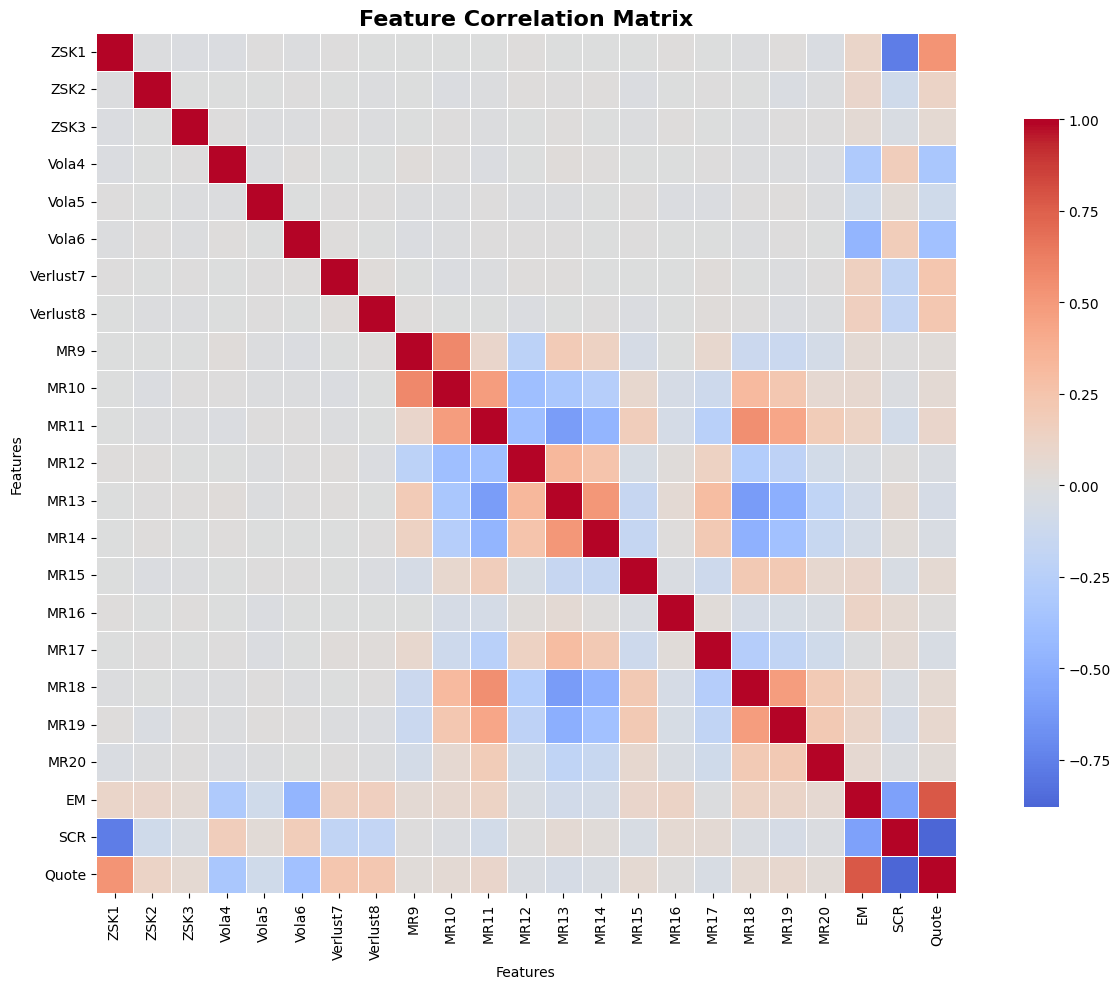

In [10]:
# Correlation matrix heatmap for all features
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

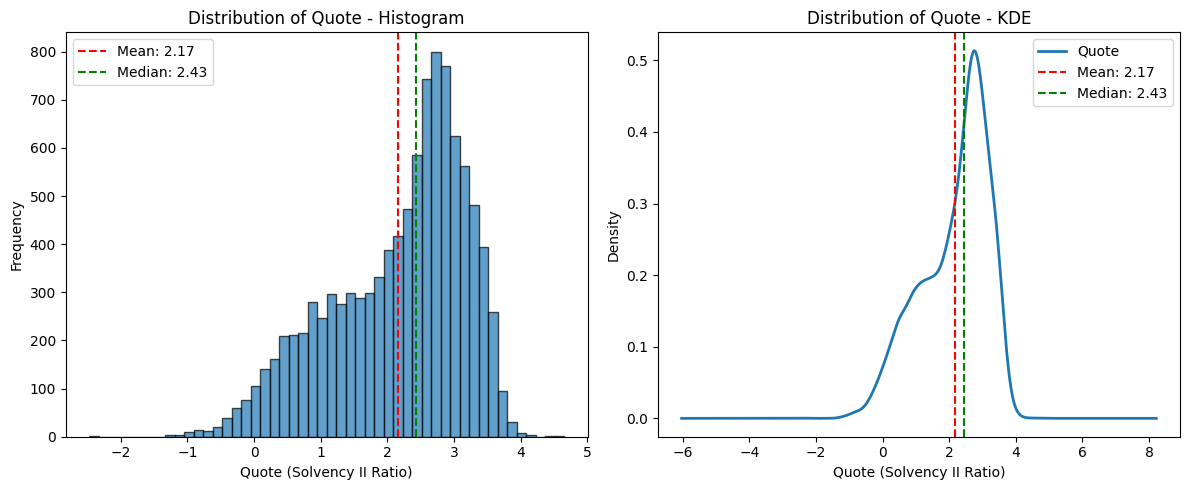

In [11]:
# Histogram/KDE of Quote
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['Quote'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Quote (Solvency II Ratio)')
plt.ylabel('Frequency')
plt.title('Distribution of Quote - Histogram')
plt.axvline(df['Quote'].mean(), color='red', linestyle='--', label=f'Mean: {df["Quote"].mean():.2f}')
plt.axvline(df['Quote'].median(), color='green', linestyle='--', label=f'Median: {df["Quote"].median():.2f}')
plt.legend()

plt.subplot(1, 2, 2)
df['Quote'].plot(kind='kde', linewidth=2)
plt.xlabel('Quote (Solvency II Ratio)')
plt.ylabel('Density')
plt.title('Distribution of Quote - KDE')
plt.axvline(df['Quote'].mean(), color='red', linestyle='--', label=f'Mean: {df["Quote"].mean():.2f}')
plt.axvline(df['Quote'].median(), color='green', linestyle='--', label=f'Median: {df["Quote"].median():.2f}')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Statistical analysis of Quote 
print(f"\nQUOTE ANALYSIS:")
print(f"Mean: {df['Quote'].mean():.3f}, Std: {df['Quote'].std():.3f}")
print(f"Range: [{df['Quote'].min():.3f}, {df['Quote'].max():.3f}]")
print(f"Skewness: {stats.skew(df['Quote']):.3f}")
print(f"Kurtosis: {stats.kurtosis(df['Quote']):.3f}")
print(f"Observations with Quote < 1 (undercapitalized): {(df['Quote'] <= 1).sum()} ({(df['Quote'] <= 1).mean()*100:.1f}%)")
print(f"Observations with Quote > 2 (well-capitalized): {(df['Quote'] >= 2).sum()} ({(df['Quote'] >= 2).mean()*100:.1f}%)")


QUOTE ANALYSIS:
Mean: 2.166, Std: 1.005
Range: [-2.472, 4.653]
Skewness: -0.695
Kurtosis: -0.299
Observations with Quote < 1 (undercapitalized): 1654 (16.2%)
Observations with Quote > 2 (well-capitalized): 6499 (63.5%)


In [13]:
# Risk type groupings for features
risk_groups = {
    'Interest Rate': ['ZSK1', 'ZSK2', 'ZSK3'],
    'Market Volatility': ['Vola4', 'Vola5', 'Vola6'],
    'Market Losses': ['Verlust7', 'Verlust8'],
    'FI/RE Allocation': ['MR9', 'MR10', 'MR11', 'MR12', 'MR13', 'MR14'],
    'Other Mgmt Rules': ['MR15', 'MR16', 'MR17', 'MR18', 'MR19', 'MR20']
}

print(f"\nFEATURE GROUPS:")
for group_name, features in risk_groups.items():
    print(f"{group_name}: {', '.join(features)}")



FEATURE GROUPS:
Interest Rate: ZSK1, ZSK2, ZSK3
Market Volatility: Vola4, Vola5, Vola6
Market Losses: Verlust7, Verlust8
FI/RE Allocation: MR9, MR10, MR11, MR12, MR13, MR14
Other Mgmt Rules: MR15, MR16, MR17, MR18, MR19, MR20



Creating target distribution analysis...


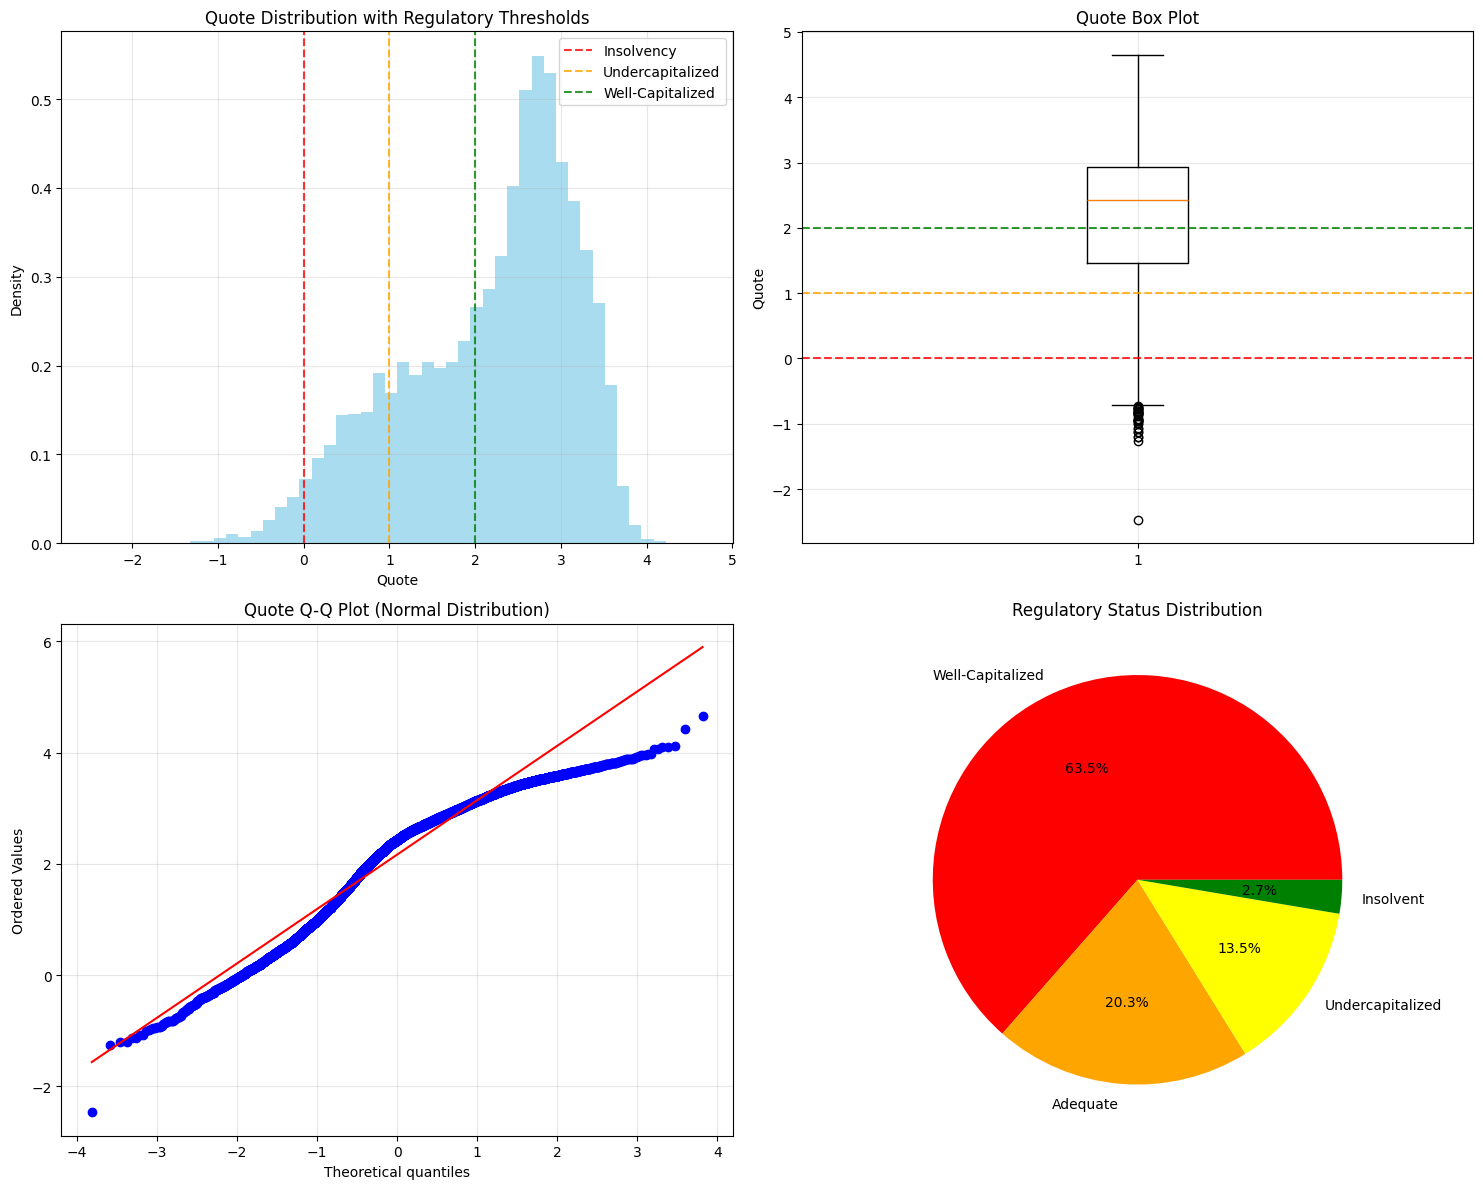

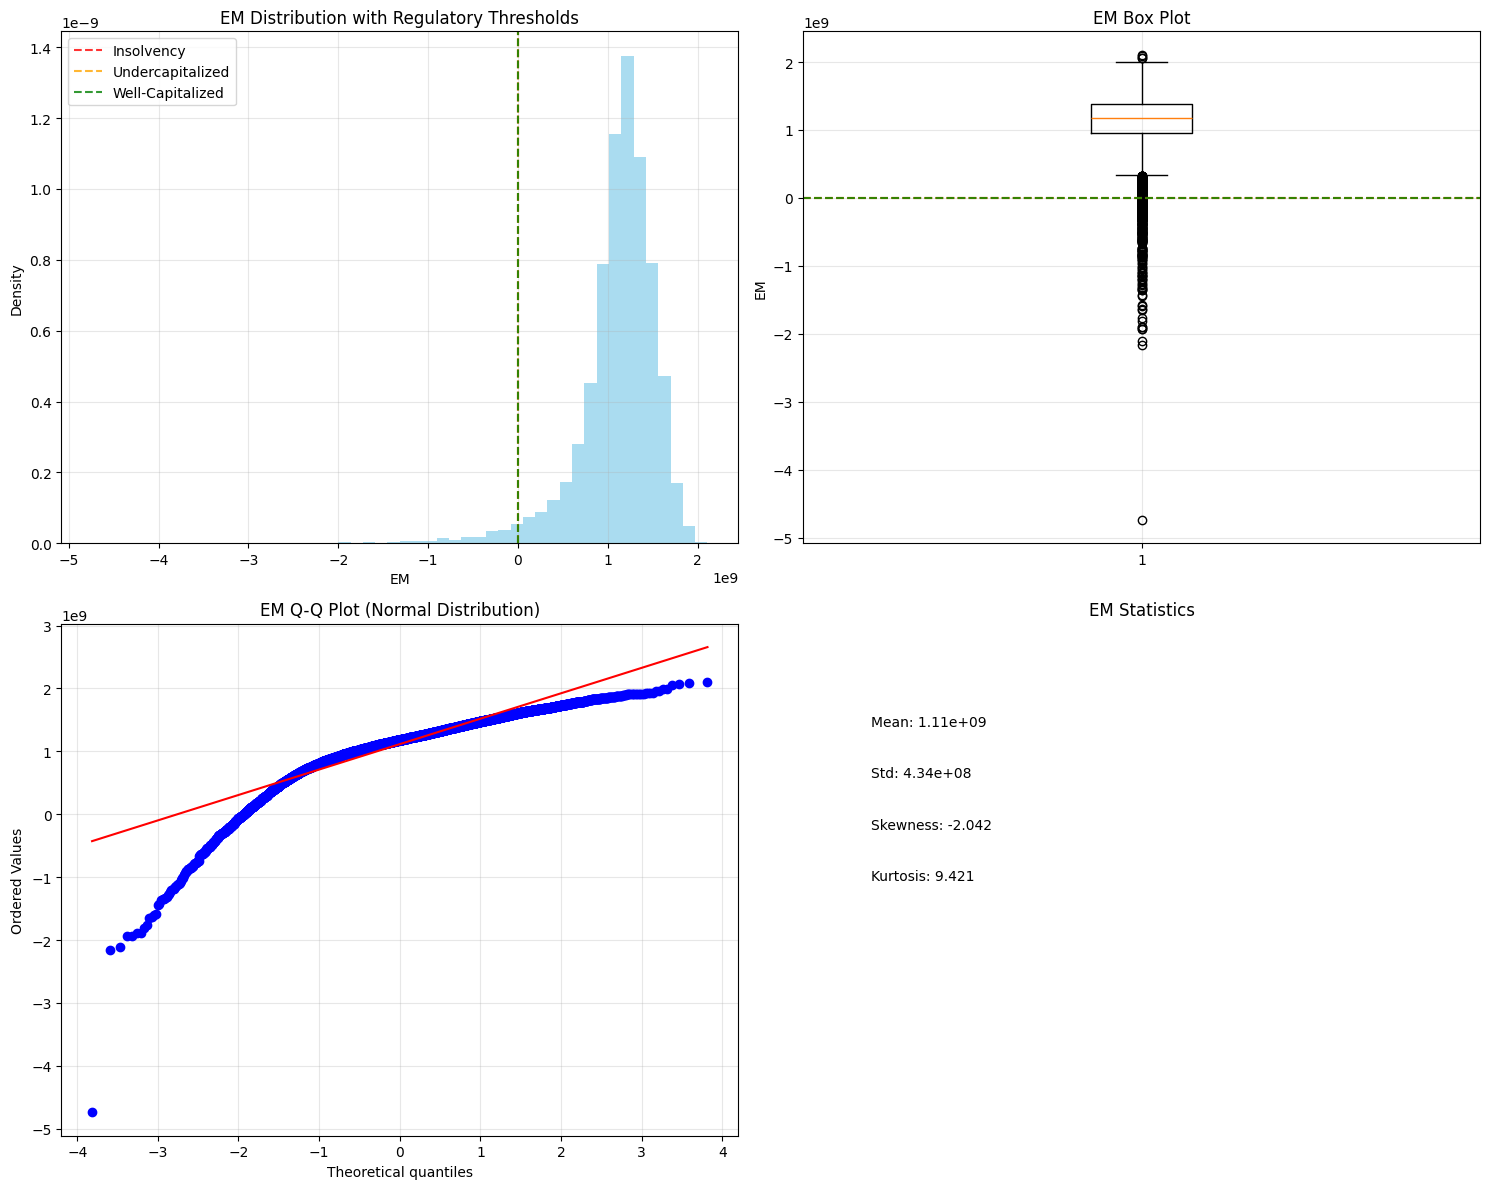

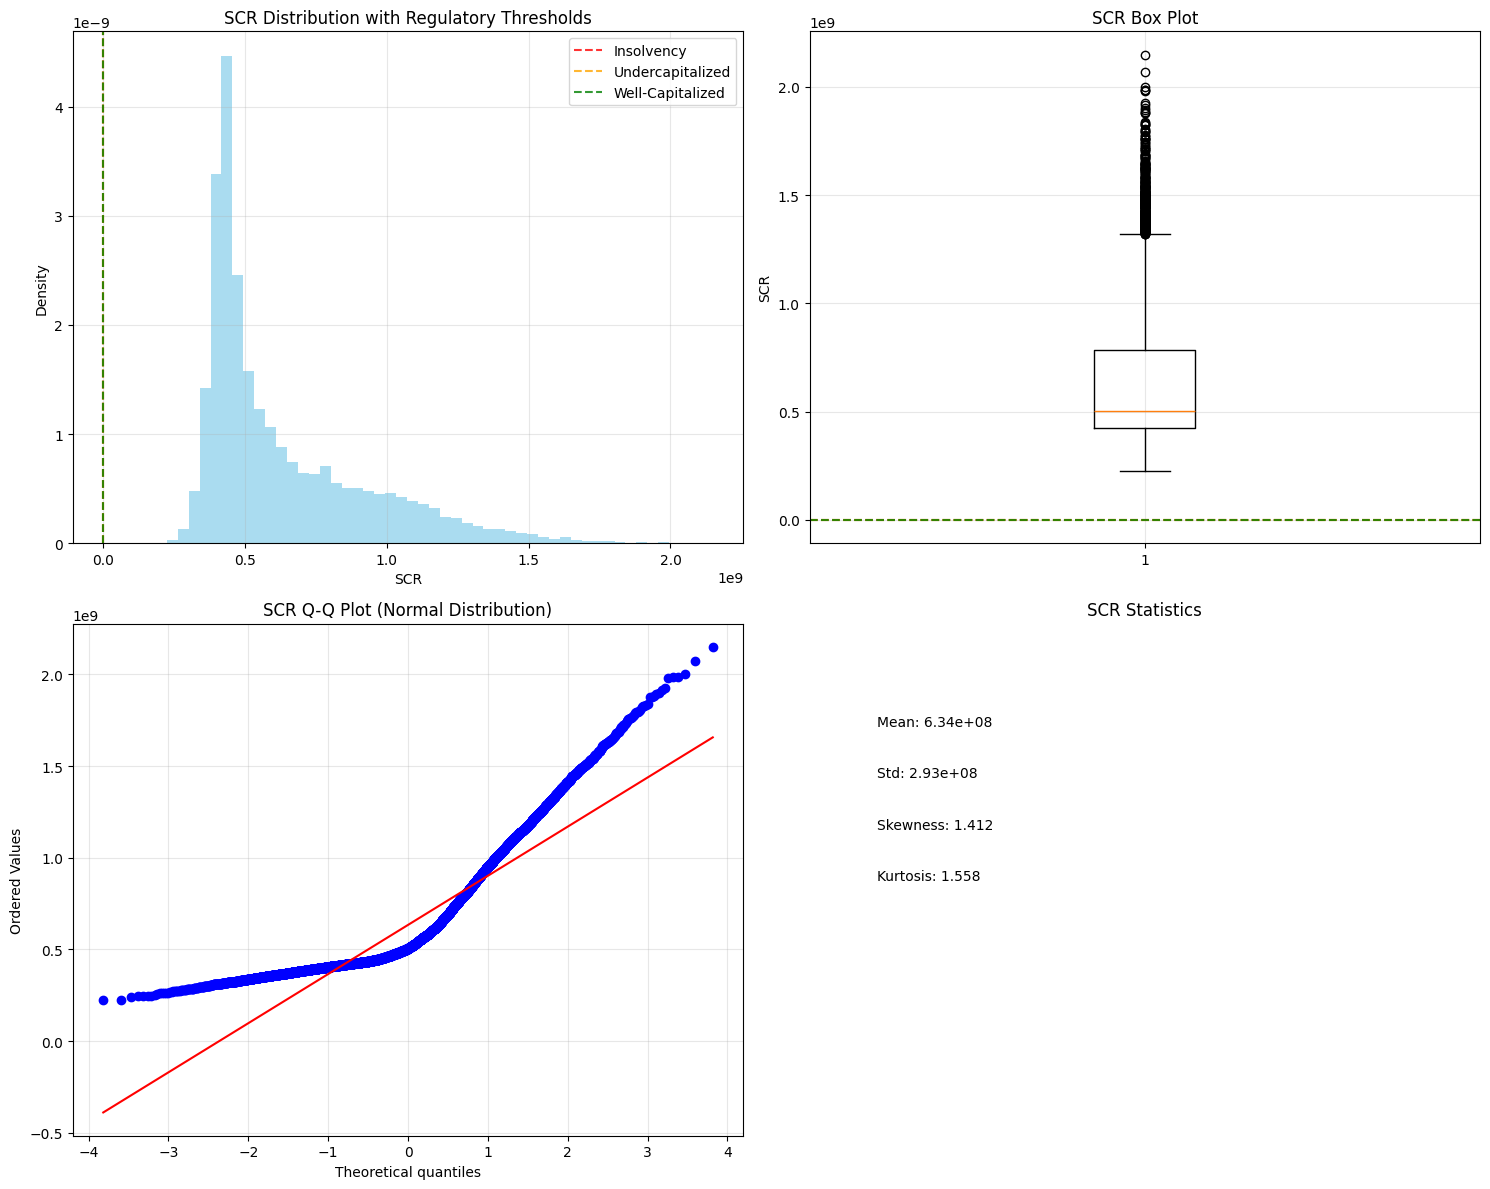

In [14]:
# Create regulatory threshold indicators for enhanced analysis
df['regulatory_status'] = pd.cut(df['Quote'], 
                                bins=[-np.inf, 0, 1, 2, np.inf], 
                                labels=['Insolvent', 'Undercapitalized', 'Adequate', 'Well-Capitalized'])

df['is_insolvent'] = (df['Quote'] < 0).astype(int)
df['is_undercapitalized'] = (df['Quote'] < 1).astype(int)
df['is_well_capitalized'] = (df['Quote'] > 2).astype(int)

# Create distribution analysis plots
print(f"\nCreating target distribution analysis...")
os.makedirs("figs", exist_ok=True)
for target in ['Quote', 'EM', 'SCR']:
    fig = plot_distribution_analysis(df, target)
    fig_path = os.path.join("figs", f"distribution_analysis_{target.lower()}.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    # plt.close(fig) 

# SECTION 2: Data preprocessing and splitting

In [15]:
# Set random seeds for reproducibility
RANDOM_STATE = 8
np.random.seed(RANDOM_STATE)

# Extract features and targets
X = df[feature_cols].copy()
y_quote = df['Quote'].copy()
y_scr = df['SCR'].copy()
y_em = df['EM'].copy()
y_multi = df[['SCR', 'EM']].copy()

print(f"Features shape: {X.shape}")
print(f"Primary target (Quote) shape: {y_quote.shape}")
print(f"Multi-target (SCR, EM) shape: {y_multi.shape}")

# Split data: Train (60%), Validation (20%), Test (20%)
X_temp, X_test, y_quote_temp, y_quote_test = train_test_split(
    X, y_quote, test_size=0.2, random_state=RANDOM_STATE
)

X_train, X_val, y_quote_train, y_quote_val = train_test_split(
    X_temp, y_quote_temp, test_size=0.25, random_state=RANDOM_STATE
)

# Split other targets accordingly
_, y_scr_test = train_test_split(y_scr, test_size=0.2, random_state=RANDOM_STATE)
_, y_em_test = train_test_split(y_em, test_size=0.2, random_state=RANDOM_STATE)
_, y_multi_test = train_test_split(y_multi, test_size=0.2, random_state=RANDOM_STATE)

y_scr_temp, _ = train_test_split(y_scr, test_size=0.2, random_state=RANDOM_STATE)
y_em_temp, _ = train_test_split(y_em, test_size=0.2, random_state=RANDOM_STATE)
y_multi_temp, _ = train_test_split(y_multi, test_size=0.2, random_state=RANDOM_STATE)

y_scr_train, y_scr_val = train_test_split(y_scr_temp, test_size=0.25, random_state=RANDOM_STATE)
y_em_train, y_em_val = train_test_split(y_em_temp, test_size=0.25, random_state=RANDOM_STATE)
y_multi_train, y_multi_val = train_test_split(y_multi_temp, test_size=0.25, random_state=RANDOM_STATE)

print(f"\nData splits:")
print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

# Create preprocessing pipeline (fit only on training data) + standarize
numeric_features = feature_cols
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features)
])

print(f"\nPreprocessing pipeline created with {len(numeric_features)} numeric features")

Features shape: (10230, 20)
Primary target (Quote) shape: (10230,)
Multi-target (SCR, EM) shape: (10230, 2)

Data splits:
Train: 6138 samples (60.0%)
Validation: 2046 samples (20.0%)
Test: 2046 samples (20.0%)

Preprocessing pipeline created with 20 numeric features


# SECTION 3: Models

## SECTION 3.1: Model Definitions

In [16]:
# Models with different complexity levels and loss functions
models_config = {
    'dummy': {
        'name': 'Dummy Regressor',
        'model': DummyRegressor(strategy='mean'),
        'loss': 'MSE'
    },
    'linear_mse': {
        'name': 'Linear Regression (MSE)',
        'model': LinearRegression(),
        'loss': 'MSE'
    },
    'linear_mae': {
        'name': 'Linear Regression (MAE)',
        'model': LinearRegression(),  # sklearn LinearRegression always uses MSE
        'loss': 'MAE'
    },
    'ridge_cv': {
        'name': 'Ridge with CV',
        'model': RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5),
        'loss': 'MSE'
    },
    'lasso_cv': {
        'name': 'Lasso with CV', 
        'model': LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, random_state=RANDOM_STATE),
        'loss': 'MSE'
    },
    # 'quadratic': {
    #     'name': 'Quadratic (Degree 2)',
    #     'model': Pipeline([
    #         ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    #         ('ridge', Ridge(alpha=1.0, random_state=RANDOM_STATE))
    #     ]),
    #     'loss': 'MSE'
    # },
    # 'cubic': {
    #     'name': 'Cubic (Degree 3)',
    #     'model': Pipeline([
    #         ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    #         ('ridge', Ridge(alpha=10.0, random_state=RANDOM_STATE))
    #     ]),
    #     'loss': 'MSE'
    # },
    'quadratic': {
    'name': 'Quadratic (Degree 2)',
    'model': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('ridge', Ridge(alpha=100.0, random_state=RANDOM_STATE))  
    ]),
    'loss': 'MSE'
    },
    'cubic': {
        'name': 'Cubic (Degree 3)', 
        'model': Pipeline([
            ('poly', PolynomialFeatures(degree=3, include_bias=False)),
            ('ridge', Ridge(alpha=1000.0, random_state=RANDOM_STATE))
        ]),
        'loss': 'MSE'
    },
    # 'elastic_net': {
    #     'name': 'Elastic Net',
    #     'model': ElasticNet(random_state=RANDOM_STATE),
    #     'loss': 'MSE',
    #     'param_grid': {
    #         'alpha': [0.01, 0.1, 1.0, 10.0],
    #         'l1_ratio': [0.1, 0.5, 0.7, 0.9]
    #     }
    # }
    'elastic_net': {
    'name': 'Elastic Net',
    'model': ElasticNet(random_state=RANDOM_STATE),
    'loss': 'MSE',
    'param_grid': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Wider range
        'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]  # More options
        }
    },
    'ridge_cv': {
        'name': 'Ridge with CV',
        'model': RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5),
        'loss': 'MSE'
    },
    'lasso_cv': {
        'name': 'Lasso with CV', 
        'model': LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, random_state=RANDOM_STATE),
        'loss': 'MSE'
    }
}

print(f"Defined {len(models_config)} model configurations:")
for key, config in models_config.items():
    print(f"  - {config['name']} (Loss: {config['loss']})")


Defined 8 model configurations:
  - Dummy Regressor (Loss: MSE)
  - Linear Regression (MSE) (Loss: MSE)
  - Linear Regression (MAE) (Loss: MAE)
  - Ridge with CV (Loss: MSE)
  - Lasso with CV (Loss: MSE)
  - Quadratic (Degree 2) (Loss: MSE)
  - Cubic (Degree 3) (Loss: MSE)
  - Elastic Net (Loss: MSE)


## SECTION 3.2: Model Training & Eval Functions

In [17]:
def train_and_evaluate_model(model_config, X_train, X_val, X_test, y_train, y_val, y_test, 
                            preprocessor, target_name, cv_folds=5):
    """Train and evaluate a single model with comprehensive metrics"""
    
    model_name = model_config['name']
    

    base_model = copy.deepcopy(model_config['model']) 
    
    print(f"\nTraining {model_name} for {target_name}...")
    
    # Create full pipeline with model copy
    if 'param_grid' in model_config:
        # Hyperparameter tuning for Elastic Net
        pipeline = Pipeline([
            ('preprocessor', copy.deepcopy(preprocessor)), 
            ('model', base_model)
        ])
        
        param_grid = {f'model__{k}': v for k, v in model_config['param_grid'].items()}
        
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=cv_folds, 
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        final_model = grid_search.best_estimator_
        
        print(f"  Best parameters: {grid_search.best_params_}")
        
    else:
        # Standard training with copies
        final_model = Pipeline([
            ('preprocessor', copy.deepcopy(preprocessor)),  
            ('model', base_model) 
        ])
        final_model.fit(X_train, y_train)
    
    # Cross-validation on training data
    cv_scores = cross_val_score(final_model, X_train, y_train, 
                            cv=cv_folds, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    
    # Predictions
    y_train_pred = final_model.predict(X_train)
    y_val_pred = final_model.predict(X_val)
    y_test_pred = final_model.predict(X_test)
    
    # Calculate metrics for all splits
    train_metrics = calculate_all_metrics(y_train, y_train_pred, "train_")
    val_metrics = calculate_all_metrics(y_val, y_val_pred, "val_")
    test_metrics = calculate_all_metrics(y_test, y_test_pred, "test_")
    
    # Combine all metrics
    all_metrics = {
        **train_metrics,
        **val_metrics, 
        **test_metrics,
        'cv_rmse_mean': cv_rmse.mean(),
        'cv_rmse_std': cv_rmse.std()
    }
    
    # Add regulatory performance analysis for Quote predictions
    if target_name == 'Quote':
        print(f"\n  Regulatory Performance Analysis for {model_name}:")
        
        # Validation set regulatory analysis
        val_reg_results = analyze_regulatory_performance(y_val, y_val_pred, f"{model_name} - Validation")
        
        # Test set regulatory analysis  
        test_reg_results = analyze_regulatory_performance(y_test, y_test_pred, f"{model_name} - Test")
        
        # Store regulatory results
        all_metrics['regulatory_val'] = val_reg_results
        all_metrics['regulatory_test'] = test_reg_results
    
    results = {
        'model': final_model,
        'model_name': model_name,
        'target_name': target_name,
        'metrics': all_metrics,
        'predictions': {
            'train': y_train_pred,
            'val': y_val_pred,
            'test': y_test_pred
        },
        'actuals': {
            'train': y_train,
            'val': y_val,
            'test': y_test
        }
    }
    
    return results

def train_multioutput_model(model_config, X_train, X_val, X_test, y_train, y_val, y_test, 
                        preprocessor, cv_folds=5):
    """Train and evaluate multi-output model for SCR and EM simultaneously"""
    
    model_name = model_config['name'] + ' (Multi-Output)'
    base_model = model_config['model']
    
    print(f"\nTraining {model_name}...")
    
    # Create multi-output pipeline
    if 'param_grid' in model_config:
        # For Elastic Net with hyperparameter tuning
        multi_model = MultiOutputRegressor(base_model)
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', multi_model)
        ])
        
        param_grid = {f'model__estimator__{k}': v for k, v in model_config['param_grid'].items()}
        
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=cv_folds, 
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        final_model = grid_search.best_estimator_
        
    else:
        # Standard multi-output training
        multi_model = MultiOutputRegressor(base_model)
        final_model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', multi_model)
        ])
        final_model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = final_model.predict(X_train)
    y_val_pred = final_model.predict(X_val)
    y_test_pred = final_model.predict(X_test)
    
    # Calculate metrics for each target separately
    target_names = ['SCR', 'EM']
    all_metrics = {}
    
    for i, target in enumerate(target_names):
        train_metrics = calculate_all_metrics(y_train.iloc[:, i], y_train_pred[:, i], f"train_{target}_")
        val_metrics = calculate_all_metrics(y_val.iloc[:, i], y_val_pred[:, i], f"val_{target}_")
        test_metrics = calculate_all_metrics(y_test.iloc[:, i], y_test_pred[:, i], f"test_{target}_")
        
        all_metrics.update({**train_metrics, **val_metrics, **test_metrics})
    
    # Calculate macro-averaged metrics
    train_rmse_macro = np.mean([all_metrics[f'train_{t}_RMSE'] for t in target_names])
    val_rmse_macro = np.mean([all_metrics[f'val_{t}_RMSE'] for t in target_names])
    test_rmse_macro = np.mean([all_metrics[f'test_{t}_RMSE'] for t in target_names])
    
    all_metrics.update({
        'train_RMSE_macro': train_rmse_macro,
        'val_RMSE_macro': val_rmse_macro,
        'test_RMSE_macro': test_rmse_macro
    })
    
    results = {
        'model': final_model,
        'model_name': model_name,
        'target_name': 'SCR_EM_Multi',
        'metrics': all_metrics,
        'predictions': {
            'train': y_train_pred,
            'val': y_val_pred,
            'test': y_test_pred
        },
        'actuals': {
            'train': y_train,
            'val': y_val,
            'test': y_test
        }
    }
    
    return results

In [18]:
all_results = {}

# Train models for Quote (primary target)
print("\nTRAINING MODELS FOR QUOTE (PRIMARY TARGET)")
all_results['quote'] = {}

for model_key, model_config in models_config.items():
    try:
        results = train_and_evaluate_model(
            model_config, X_train, X_val, X_test, 
            y_quote_train, y_quote_val, y_quote_test,
            preprocessor, "Quote"
        )
        all_results['quote'][model_key] = results
        
        # Print summary metrics
        metrics = results['metrics']
        print(f"  {results['model_name']}:")
        print(f"    CV RMSE: {metrics['cv_rmse_mean']:.4f} (±{metrics['cv_rmse_std']:.4f})")
        print(f"    Val RMSE: {metrics['val_RMSE']:.4f}")
        print(f"    Test RMSE: {metrics['test_RMSE']:.4f}")
        
    except Exception as e:
        print(f"  Error training {model_config['name']}: {str(e)}")

# Train models for SCR (secondary target)
print("\nTRAINING MODELS FOR SCR (SECONDARY TARGET)")
all_results['scr'] = {}

for model_key, model_config in models_config.items():
    try:
        results = train_and_evaluate_model(
            model_config, X_train, X_val, X_test,
            y_scr_train, y_scr_val, y_scr_test,
            preprocessor, "SCR"
        )
        all_results['scr'][model_key] = results
        
        metrics = results['metrics']
        print(f"  {results['model_name']}:")
        print(f"    CV RMSE: {metrics['cv_rmse_mean']:.4f} (±{metrics['cv_rmse_std']:.4f})")
        print(f"    Val RMSE: {metrics['val_RMSE']:.4f}")
        print(f"    Test RMSE: {metrics['test_RMSE']:.4f}")
        
    except Exception as e:
        print(f"  Error training {model_config['name']}: {str(e)}")

# Train models for EM (secondary target)
print("\nTRAINING MODELS FOR EM (SECONDARY TARGET)")
all_results['em'] = {}

for model_key, model_config in models_config.items():
    try:
        results = train_and_evaluate_model(
            model_config, X_train, X_val, X_test,
            y_em_train, y_em_val, y_em_test,
            preprocessor, "EM"
        )
        all_results['em'][model_key] = results
        
        metrics = results['metrics']
        print(f"  {results['model_name']}:")
        print(f"    CV RMSE: {metrics['cv_rmse_mean']:.4f} (±{metrics['cv_rmse_std']:.4f})")
        print(f"    Val RMSE: {metrics['val_RMSE']:.4f}")
        print(f"    Test RMSE: {metrics['test_RMSE']:.4f}")
        
    except Exception as e:
        print(f"  Error training {model_config['name']}: {str(e)}")

# Train multi-output models for SCR and EM
print("\nTRAINING MULTI-OUTPUT MODELS FOR SCR & EM")
all_results['multi_output'] = {}

for model_key, model_config in models_config.items():
    try:
        results = train_multioutput_model(
            model_config, X_train, X_val, X_test,
            y_multi_train, y_multi_val, y_multi_test,
            preprocessor
        )
        all_results['multi_output'][model_key] = results
        
        metrics = results['metrics']
        print(f"  {results['model_name']}:")
        print(f"    Val RMSE (SCR): {metrics['val_SCR_RMSE']:.4f}")
        print(f"    Val RMSE (EM): {metrics['val_EM_RMSE']:.4f}")
        print(f"    Val RMSE (Macro): {metrics['val_RMSE_macro']:.4f}")
        
    except Exception as e:
        print(f"  Error training multi-output {model_config['name']}: {str(e)}")



TRAINING MODELS FOR QUOTE (PRIMARY TARGET)

Training Dummy Regressor for Quote...

  Regulatory Performance Analysis for Dummy Regressor:

REGULATORY PERFORMANCE ANALYSIS - Dummy Regressor - Validation

Insolvent (61 obs, 3.0%):
  RMSE: 2.5066
  MAE: 2.4891
  R²: -71.0268

Undercapitalized (273 obs, 13.3%):
  RMSE: 1.5990
  MAE: 1.5763
  R²: -34.5268

Adequate (418 obs, 20.4%):
  RMSE: 0.7034
  MAE: 0.6387
  R²: -4.6981

Well-Capitalized (1294 obs, 63.2%):
  RMSE: 0.7770
  MAE: 0.6565
  R²: -2.2303

REGULATORY PERFORMANCE ANALYSIS - Dummy Regressor - Test

Insolvent (57 obs, 2.8%):
  RMSE: 2.4627
  MAE: 2.4474
  R²: -80.1726

Undercapitalized (271 obs, 13.2%):
  RMSE: 1.6237
  MAE: 1.5988
  R²: -31.8478

Adequate (422 obs, 20.6%):
  RMSE: 0.7052
  MAE: 0.6476
  R²: -5.3804

Well-Capitalized (1296 obs, 63.3%):
  RMSE: 0.7900
  MAE: 0.6718
  R²: -2.2994
  Dummy Regressor:
    CV RMSE: 1.0040 (±0.0153)
    Val RMSE: 1.0057
    Test RMSE: 1.0080

Training Linear Regression (MSE) for Quote

## SECTION 3.3: Model Comaprision & Selection

In [19]:
def create_comparison_table(results_dict, target_name):
    """Create comparison table for models"""
    comparison_data = []
    
    for model_key, results in results_dict.items():
        if results is None:
            continue
            
        metrics = results['metrics']
        row = {
            'Model': results['model_name'],
            'CV_RMSE_Mean': metrics.get('cv_rmse_mean', np.nan),
            'CV_RMSE_Std': metrics.get('cv_rmse_std', np.nan),
            'Val_RMSE': metrics.get('val_RMSE', metrics.get('val_RMSE_macro', np.nan)),
            'Val_MAE': metrics.get('val_MAE', np.nan),
            'Val_R2': metrics.get('val_R2', np.nan),
            'Test_RMSE': metrics.get('test_RMSE', metrics.get('test_RMSE_macro', np.nan)),
            'Test_MAE': metrics.get('test_MAE', np.nan),
            'Test_R2': metrics.get('test_R2', np.nan)
        }
        comparison_data.append(row)
    
    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('Val_RMSE')
    
    print(f"\n{target_name} Model Comparison (sorted by Validation RMSE):")
    print("="*80)
    print(df_comparison.round(4).to_string(index=False))
    
    return df_comparison

# Create comparison tables
quote_comparison = create_comparison_table(all_results['quote'], "QUOTE")
scr_comparison = create_comparison_table(all_results['scr'], "SCR") 
em_comparison = create_comparison_table(all_results['em'], "EM")
multi_comparison = create_comparison_table(all_results['multi_output'], "MULTI-OUTPUT (SCR & EM)")

# Select best models based on validation performance
best_models = {}

for target, results_dict in [('quote', all_results['quote']), 
                            ('scr', all_results['scr']), 
                            ('em', all_results['em']),
                            ('multi_output', all_results['multi_output'])]:
    
    if not results_dict:
        continue
        
    best_key = None
    best_val_rmse = float('inf')
    
    for model_key, results in results_dict.items():
        if results is None:
            continue
            
        val_rmse = results['metrics'].get('val_RMSE', results['metrics'].get('val_RMSE_macro', float('inf')))
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_key = model_key
    
    if best_key:
        best_models[target] = {
            'key': best_key,
            'results': results_dict[best_key],
            'val_rmse': best_val_rmse
        }

print("\nBEST MODELS SELECTED: ")
for target, best_info in best_models.items():
    print(f"{target.upper()}: {best_info['results']['model_name']} "
            f"(Val RMSE: {best_info['val_rmse']:.4f})")



QUOTE Model Comparison (sorted by Validation RMSE):
                  Model  CV_RMSE_Mean  CV_RMSE_Std  Val_RMSE  Val_MAE  Val_R2  Test_RMSE  Test_MAE  Test_R2
   Quadratic (Degree 2)        0.3138       0.0149    0.3208   0.2388  0.8982     0.3182    0.2369   0.9004
       Cubic (Degree 3)        0.5721       0.0267    0.5645   0.3249  0.6849     0.4741    0.2965   0.7788
          Lasso with CV        0.5800       0.0267    0.5813   0.4585  0.6659     0.5693    0.4529   0.6811
          Ridge with CV        0.5800       0.0267    0.5813   0.4583  0.6659     0.5692    0.4527   0.6812
            Elastic Net        0.5800       0.0267    0.5813   0.4582  0.6659     0.5692    0.4527   0.6812
Linear Regression (MSE)        0.5800       0.0268    0.5813   0.4581  0.6659     0.5691    0.4526   0.6812
Linear Regression (MAE)        0.5800       0.0268    0.5813   0.4581  0.6659     0.5691    0.4526   0.6812
        Dummy Regressor        1.0040       0.0153    1.0057   0.8302 -0.0000     1

## SECTION 3.4: Feature Importance Analysis

In [20]:
def get_polynomial_feature_importance(model, feature_names, target_name):
    """Extract feature importance from polynomial ridge models"""
    
    print(f"\nAnalyzing feature importance for {target_name}...")
    
    try:
        # Navigate through nested pipelines
        if hasattr(model, 'named_steps'):
            # First level: get the inner model from the outer pipeline
            inner_model = model.named_steps['model']
            
            # Check if inner model is also a pipeline (polynomial models)
            if hasattr(inner_model, 'named_steps') and 'poly' in inner_model.named_steps:
                # This is a polynomial model
                ridge_model = inner_model.named_steps['ridge']
                poly_features = inner_model.named_steps['poly']
                
                # Get polynomial feature names
                poly_feature_names = poly_features.get_feature_names_out(feature_names)
                coefficients = ridge_model.coef_
                
                # Calculate importance as absolute coefficient values
                importance_scores = np.abs(coefficients)
                
                # Create importance DataFrame
                importance_df = pd.DataFrame({
                    'Feature': poly_feature_names,
                    'Coefficient': coefficients,
                    'Importance': importance_scores
                }).sort_values('Importance', ascending=False)
                
                # Aggregate by original feature (sum importance of all polynomial terms)
                original_importance = {}
                for original_feature in feature_names:
                    # Sum importance of all terms containing this feature
                    mask = [original_feature in feat for feat in poly_feature_names]
                    total_importance = importance_scores[mask].sum()
                    original_importance[original_feature] = total_importance
                
                # Create aggregated importance DataFrame
                aggregated_df = pd.DataFrame([
                    {'Feature': feat, 'Total_Importance': imp} 
                    for feat, imp in original_importance.items()
                ]).sort_values('Total_Importance', ascending=False)
                
                print(f"Top 10 most important original features for {target_name}:")
                print(aggregated_df.head(10).to_string(index=False))
                
                print(f"\nTop 10 most important polynomial terms for {target_name}:")
                print(importance_df[['Feature', 'Importance']].head(10).to_string(index=False))
                
                return {
                    'polynomial_importance': importance_df,
                    'aggregated_importance': aggregated_df,
                    'coefficients': coefficients
                }
            else:
                coefficients = inner_model.coef_
                importance_scores = np.abs(coefficients)
                
                importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Coefficient': coefficients,
                    'Importance': importance_scores
                }).sort_values('Importance', ascending=False)
                
                print(f"Top 10 most important features for {target_name}:")
                print(importance_df.head(10).to_string(index=False))
                
                return {
                    'aggregated_importance': importance_df,
                    'coefficients': coefficients
                }
        else:
            print(f"Model structure not recognized for {target_name}")
            return None
            
    except Exception as e:
        print(f"Error in feature importance analysis for {target_name}: {str(e)}")
        print(f"Model structure: {type(model)}")
        if hasattr(model, 'named_steps'):
            print(f"Outer pipeline steps: {list(model.named_steps.keys())}")
            if 'model' in model.named_steps and hasattr(model.named_steps['model'], 'named_steps'):
                print(f"Inner pipeline steps: {list(model.named_steps['model'].named_steps.keys())}")
        return None

# Perform feature importance analysis for best models
feature_importance_results = {}

for target, best_info in best_models.items():
    if target == 'multi_output':
        continue  # Skip multi-output for simplicity
        
    importance_result = get_polynomial_feature_importance(
        best_info['results']['model'], feature_cols, target.upper()
    )
    if importance_result:
        feature_importance_results[target] = importance_result



Analyzing feature importance for QUOTE...
Top 10 most important original features for QUOTE:
 Feature  Total_Importance
    ZSK1          1.592020
   Vola6          0.967888
   Vola4          0.606925
Verlust7          0.574927
Verlust8          0.532979
    ZSK2          0.323813
   Vola5          0.245725
    MR11          0.218971
    ZSK3          0.164517
    MR13          0.151973

Top 10 most important polynomial terms for QUOTE:
   Feature  Importance
      ZSK1    0.511662
    ZSK1^2    0.392451
     Vola6    0.375650
     Vola4    0.305011
ZSK1 Vola6    0.245398
  Verlust7    0.228734
  Verlust8    0.227732
      ZSK2    0.130438
ZSK1 Vola4    0.106928
     Vola5    0.090289

Analyzing feature importance for SCR...
Top 10 most important original features for SCR:
 Feature  Total_Importance
    ZSK1      5.191952e+08
Verlust8      1.678459e+08
   Vola6      1.595023e+08
Verlust7      1.521163e+08
   Vola4      1.243920e+08
    ZSK2      7.438106e+07
    MR11      6.944626e+07

## SECTION 3.5: Robustness Analysis

In [21]:
def analyze_prediction_stability(model, X_test, y_test, target_name):
    """Analyze prediction stability across different data segments"""
    
    print(f"\nAnalyzing prediction stability for {target_name}...")
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Overall performance
    overall_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    overall_r2 = r2_score(y_test, y_pred)
    overall_mae = mean_absolute_error(y_test, y_pred)
    
    print(f"Overall Performance:")
    print(f"  RMSE: {overall_rmse:.4f}")
    print(f"  MAE: {overall_mae:.4f}")
    print(f"  R²: {overall_r2:.4f}")
    
    # Analyze performance across different target value ranges
    if target_name == 'QUOTE':
        # Regulatory thresholds
        ranges = [
            ('Insolvent', y_test < 0),
            ('Undercapitalized', (y_test >= 0) & (y_test < 1)),
            ('Adequate', (y_test >= 1) & (y_test <= 2)),
            ('Well-Capitalized', y_test > 2)
        ]
        
        print(f"\nREGULATORY PERFORMANCE BREAKDOWN: ")
        
    else:
        # Quartile-based analysis
        q25, q50, q75 = np.percentile(y_test, [25, 50, 75])
        ranges = [
            ('Q1 (Low)', y_test <= q25),
            ('Q2 (Med-Low)', (y_test > q25) & (y_test <= q50)),
            ('Q3 (Med-High)', (y_test > q50) & (y_test <= q75)),
            ('Q4 (High)', y_test > q75)
        ]
        
        print(f"\nPerformance by {target_name} quartiles:")
    
    range_results = {}
    for range_name, mask in ranges:
        if np.sum(mask) > 0:
            range_rmse = np.sqrt(mean_squared_error(y_test[mask], y_pred[mask]))
            range_mae = mean_absolute_error(y_test[mask], y_pred[mask])
            range_r2 = r2_score(y_test[mask], y_pred[mask])
            
            range_results[range_name] = {
                'count': np.sum(mask),
                'percentage': np.sum(mask) / len(y_test) * 100,
                'rmse': range_rmse,
                'mae': range_mae,
                'r2': range_r2
            }
            
            print(f"  {range_name} ({np.sum(mask)} obs, {np.sum(mask)/len(y_test)*100:.1f}%):")
            print(f"    RMSE: {range_rmse:.4f}")
            print(f"    MAE: {range_mae:.4f}")
            print(f"    R²: {range_r2:.4f}")
    
    # Additional stability metrics
    residuals = y_test - y_pred
    residual_std = np.std(residuals)
    
    print(f"\nSTABILITY METRICS: ")
    print(f"  Residual Standard Deviation: {residual_std:.4f}")
    print(f"  Mean Absolute Residual: {np.mean(np.abs(residuals)):.4f}")
    print(f"  95th Percentile Absolute Error: {np.percentile(np.abs(residuals), 95):.4f}")
    
    return {
        'overall_rmse': overall_rmse,
        'overall_mae': overall_mae,
        'overall_r2': overall_r2,
        'range_analysis': range_results,
        'residual_std': residual_std
    }

# Perform stability analysis for best models
stability_results = {}

for target, best_info in best_models.items():
    if target == 'multi_output':
        print(f"\nSkipping stability analysis for multi-output model")
        continue
        
    # Get the appropriate test target
    if target == 'quote':
        y_target_test = y_quote_test
    elif target == 'scr':
        y_target_test = y_scr_test
    elif target == 'em':
        y_target_test = y_em_test
        
    stability_result = analyze_prediction_stability(
        best_info['results']['model'], X_test, y_target_test, target.upper()
    )
    
    stability_results[target] = stability_result



Analyzing prediction stability for QUOTE...
Overall Performance:
  RMSE: 0.3182
  MAE: 0.2369
  R²: 0.9004

REGULATORY PERFORMANCE BREAKDOWN: 
  Insolvent (57 obs, 2.8%):
    RMSE: 0.6191
    MAE: 0.4791
    R²: -4.1302
  Undercapitalized (271 obs, 13.2%):
    RMSE: 0.4077
    MAE: 0.3048
    R²: -1.0706
  Adequate (422 obs, 20.6%):
    RMSE: 0.3452
    MAE: 0.2836
    R²: -0.5289
  Well-Capitalized (1296 obs, 63.3%):
    RMSE: 0.2635
    MAE: 0.1968
    R²: 0.6331

STABILITY METRICS: 
  Residual Standard Deviation: 0.3181
  Mean Absolute Residual: 0.2369
  95th Percentile Absolute Error: 0.6360

Analyzing prediction stability for SCR...
Overall Performance:
  RMSE: 99540424.6750
  MAE: 60836852.7500
  R²: 0.8905

Performance by SCR quartiles:
  Q1 (Low) (512 obs, 25.0%):
    RMSE: 54324024.2139
    MAE: 42301559.1733
    R²: -1.6715
  Q2 (Med-Low) (511 obs, 25.0%):
    RMSE: 50913775.2578
    MAE: 39792717.0695
    R²: -4.0767
  Q3 (Med-High) (511 obs, 25.0%):
    RMSE: 72332422.7669

## SECTION 3.6: Visuals


Creating visualizations for QUOTE - Quadratic (Degree 2)


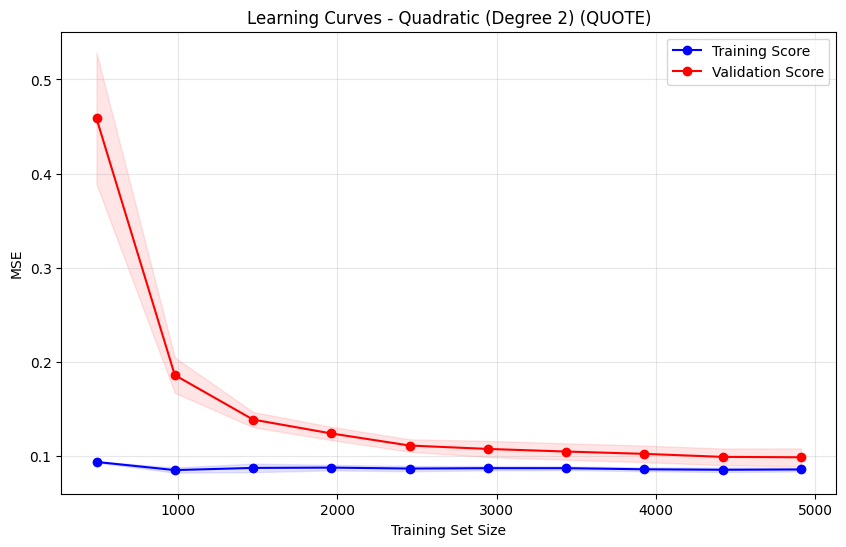

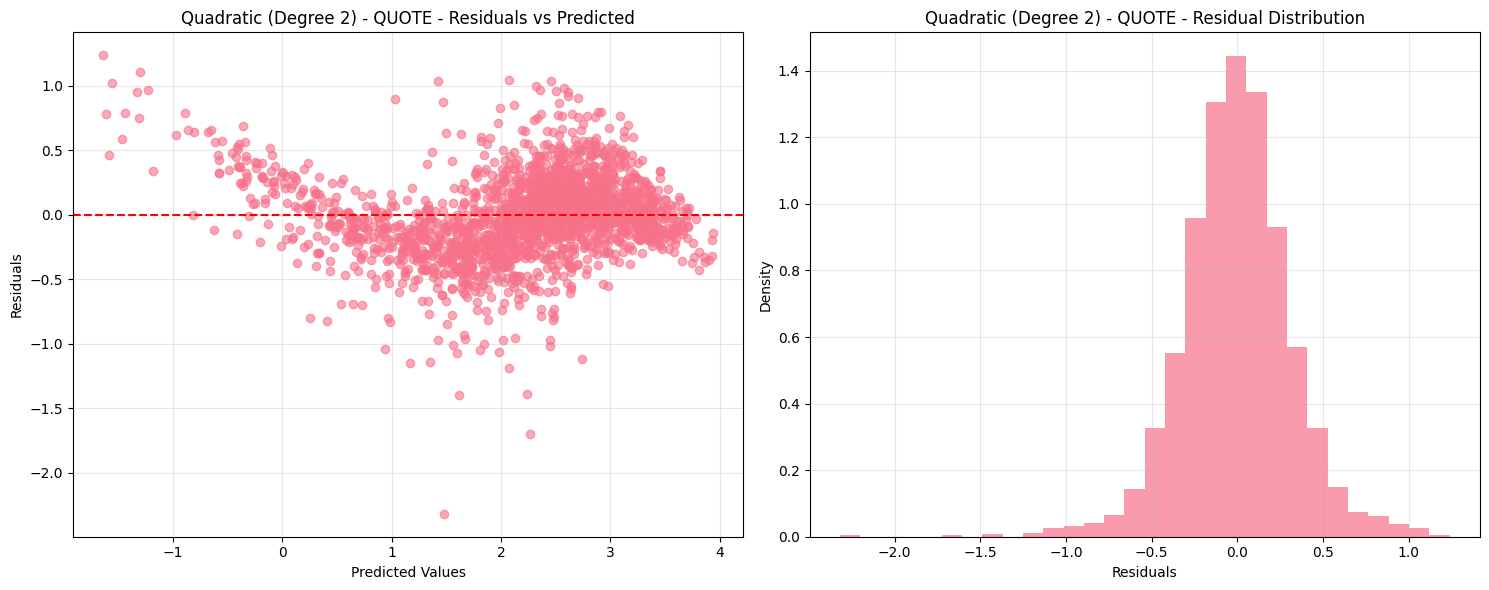

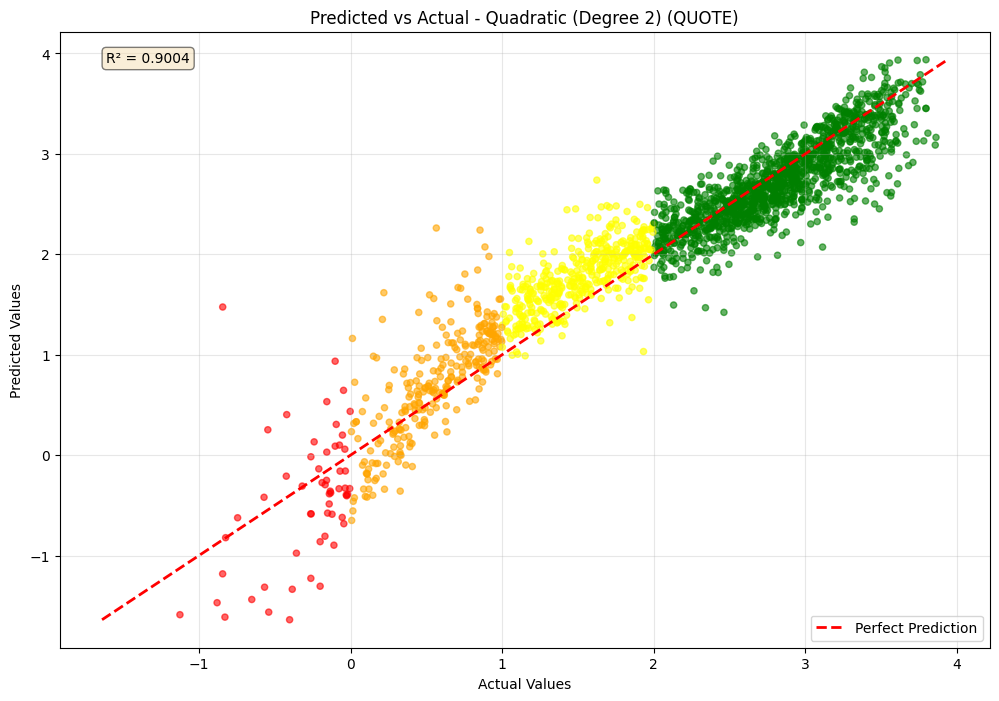


Creating visualizations for SCR - Quadratic (Degree 2)


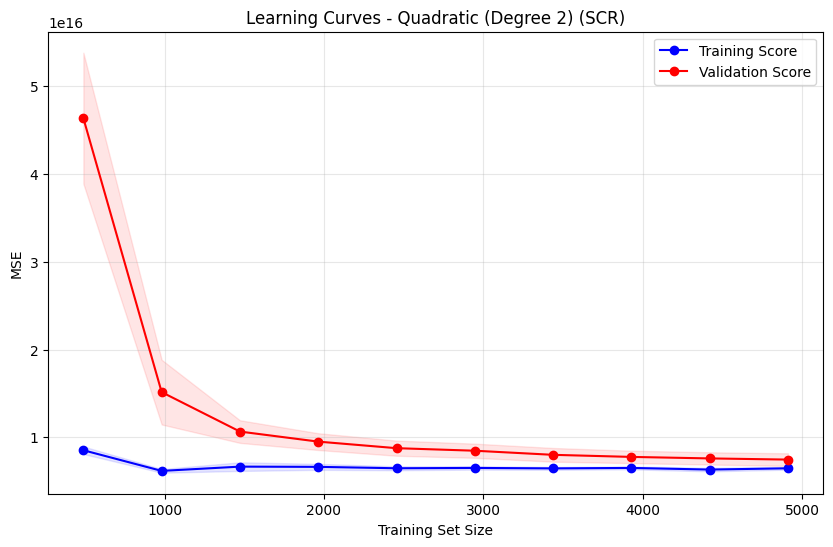

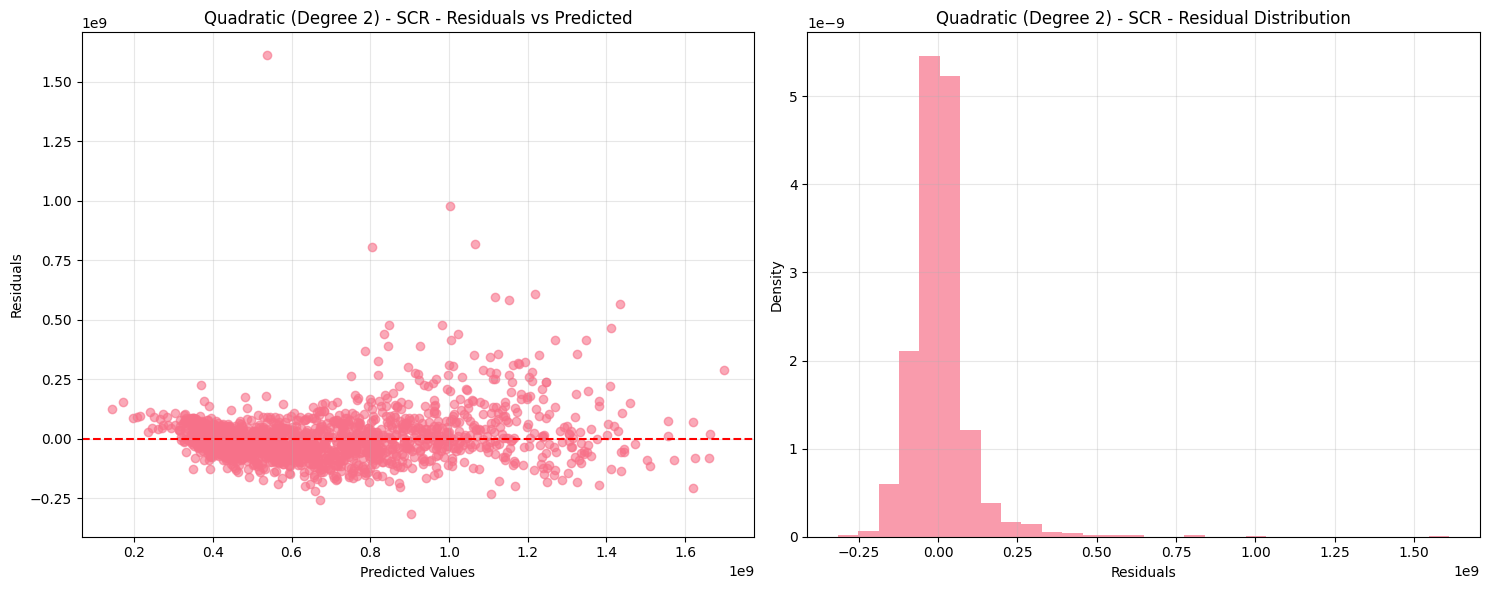

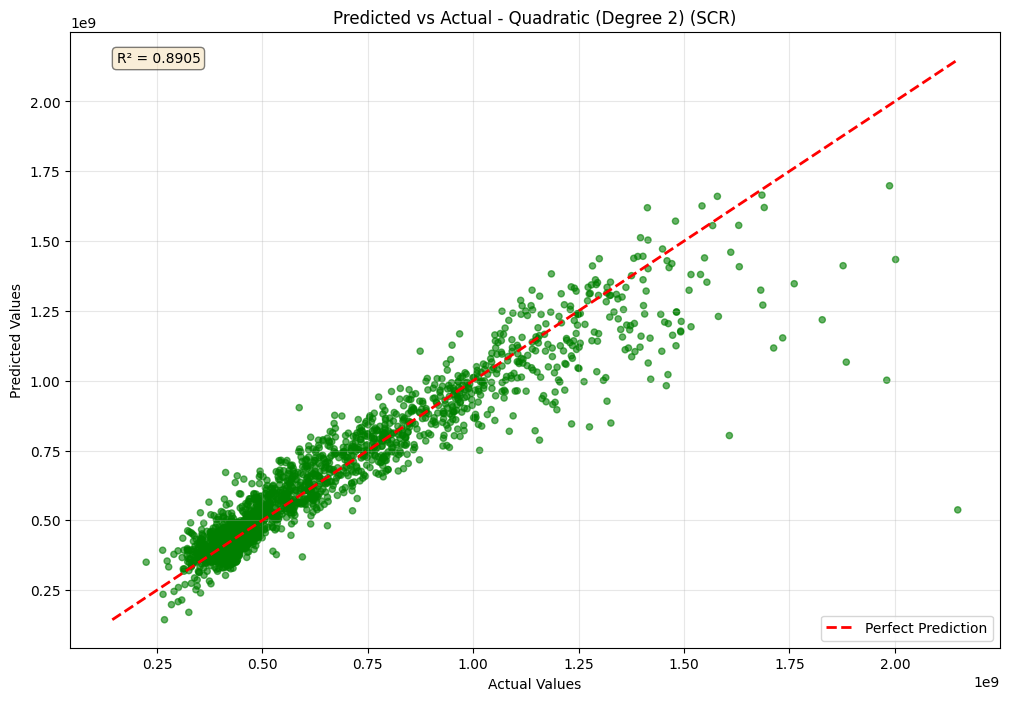


Creating visualizations for EM - Quadratic (Degree 2)


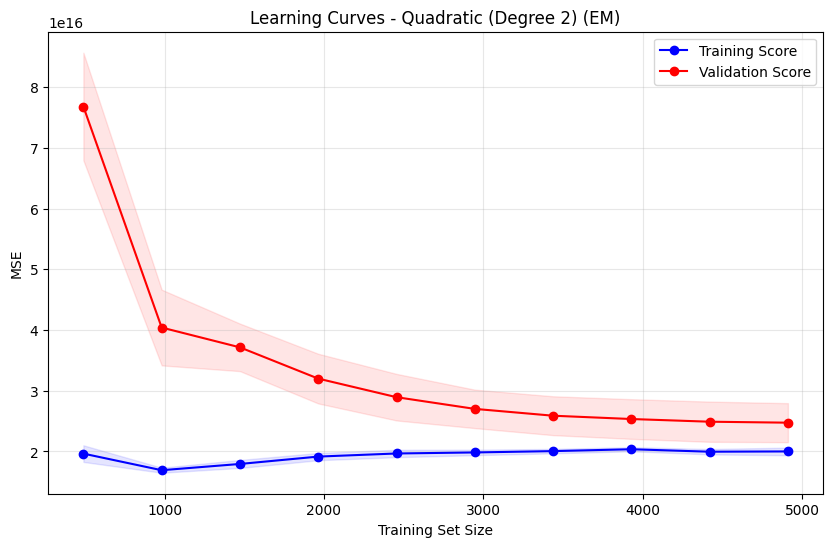

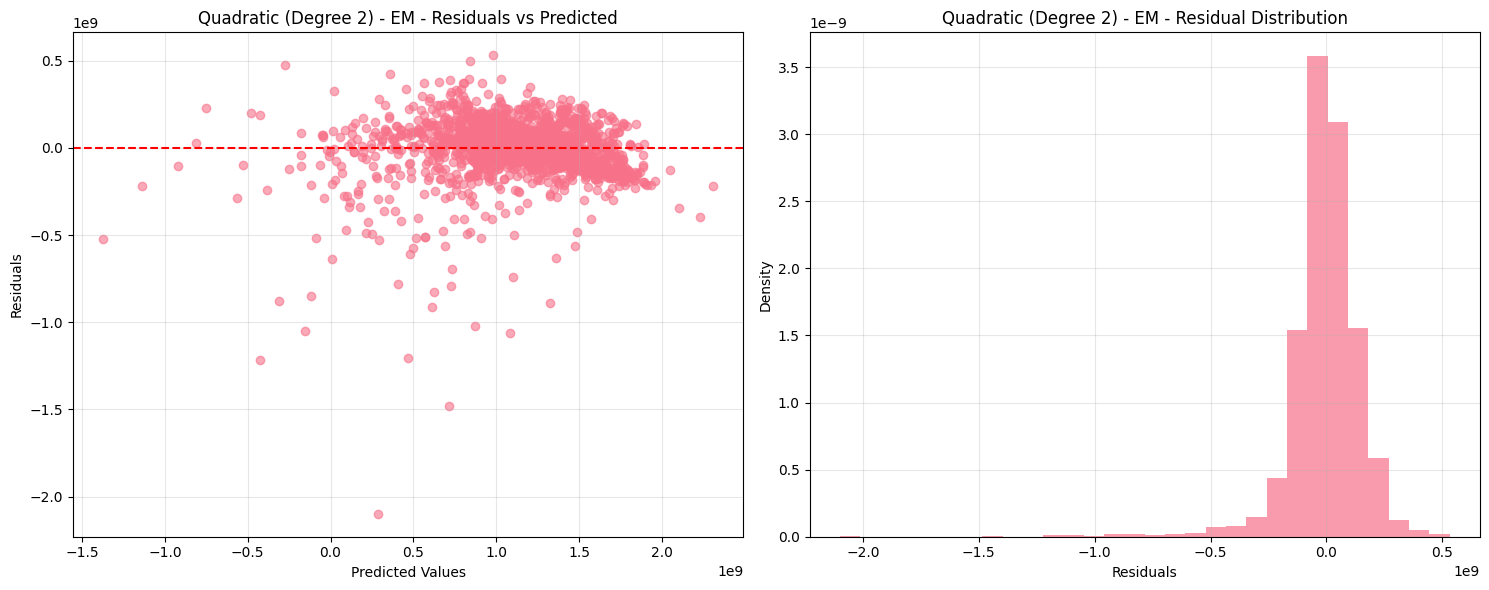

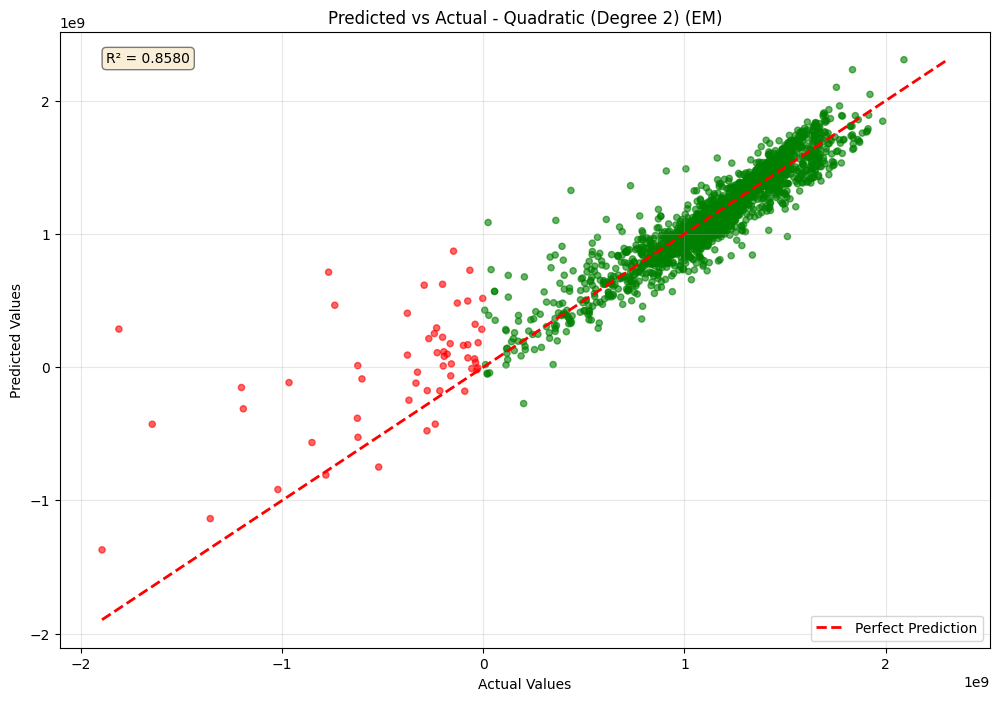


Creating visualizations for MULTI_OUTPUT - Quadratic (Degree 2) (Multi-Output)
  Skipping learning curves for multi-output model (complex to visualize)


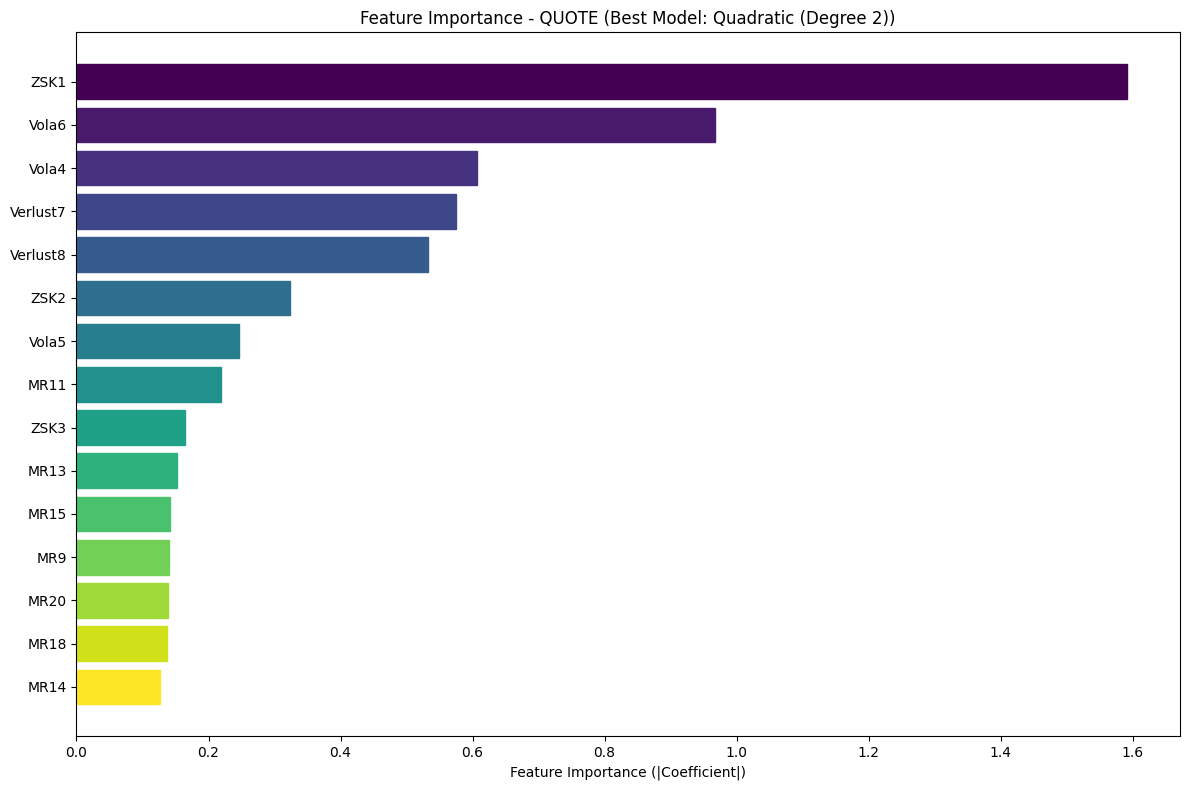

✅ Created feature importance plot for QUOTE


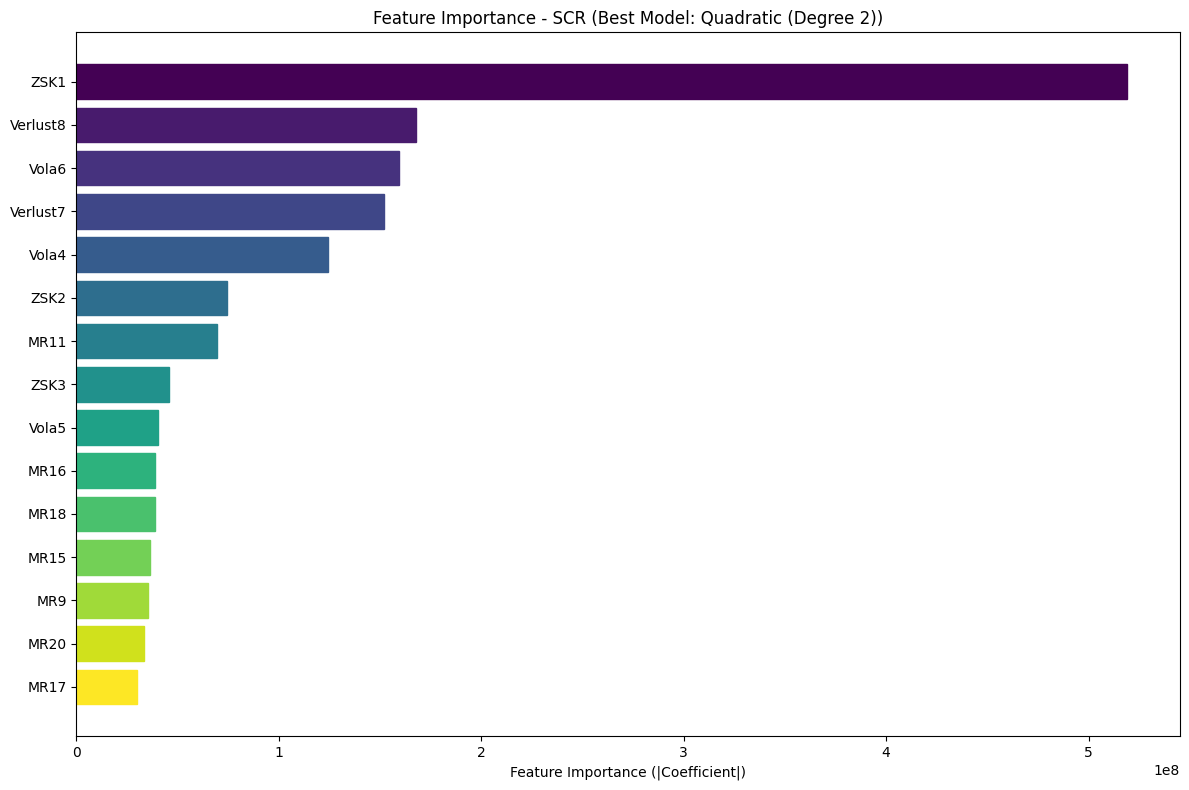

✅ Created feature importance plot for SCR


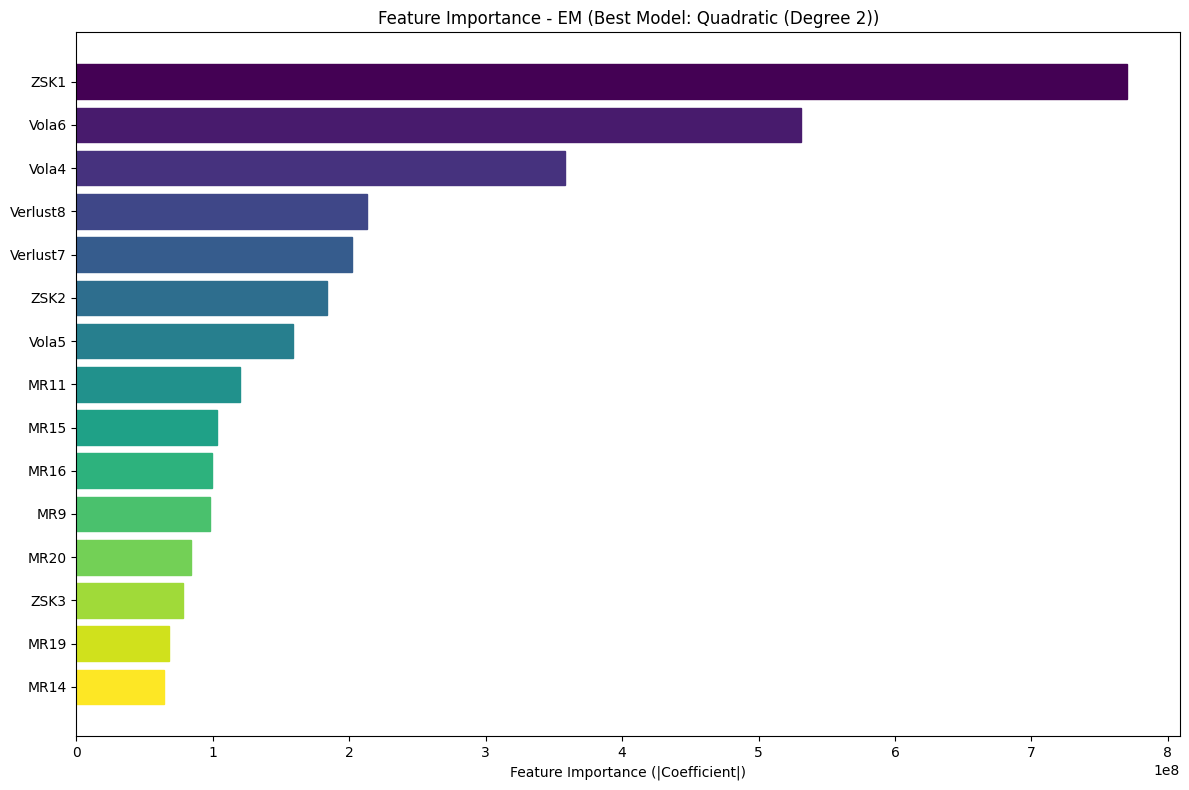

✅ Created feature importance plot for EM

Creating model performance comparison heatmap...


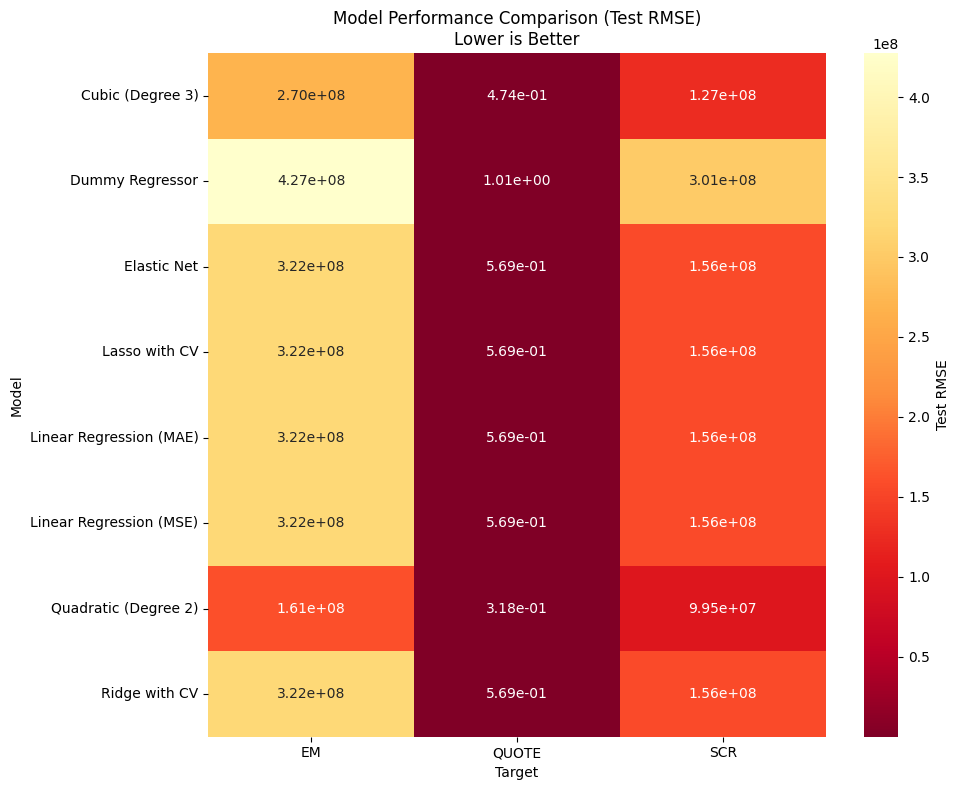

✅ Created performance comparison heatmap

Creating regulatory performance visualization for Quote...


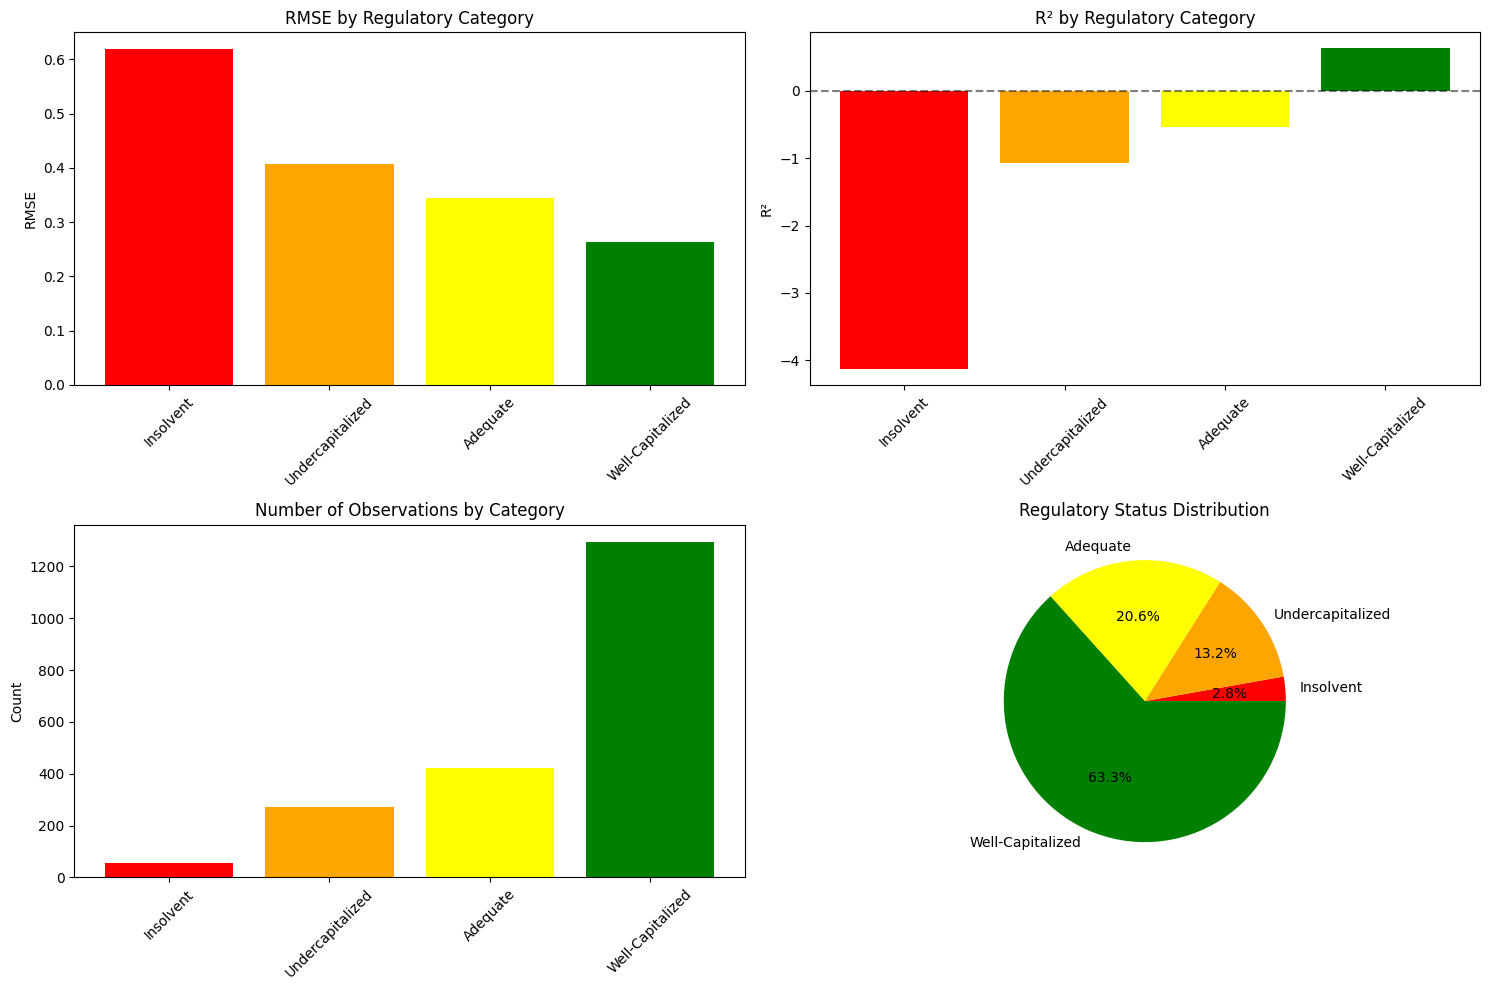

✅ Created regulatory performance analysis


In [22]:
# Plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create visualizations for best models
fig_counter = 1

for target, best_info in best_models.items():
    results = best_info['results']
    model_name = results['model_name']
    
    print(f"\nCreating visualizations for {target.upper()} - {model_name}")
    
    # 1. Learning Curves
    try:
        if target == 'multi_output':
            print(f"  Skipping learning curves for multi-output model (complex to visualize)")
            continue  # Skip learning curves for multi-output
        elif target == 'quote':
            y_train_target = y_quote_train
        elif target == 'scr':
            y_train_target = y_scr_train
        elif target == 'em':
            y_train_target = y_em_train
            
        fig = plot_learning_curves(results['model'], X_train, y_train_target)
        plt.title(f'Learning Curves - {model_name} ({target.upper()})')
        plt.savefig(f'figs/learning_curves_{target}_{fig_counter}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Error creating learning curves: {str(e)}")
    
    # 2. Residual Plots
    try:
        if target == 'multi_output':
            # For multi-output, create plots for each target
            for i, sub_target in enumerate(['SCR', 'EM']):
                y_true = results['actuals']['test'].iloc[:, i]
                y_pred = results['predictions']['test'][:, i]
                
                fig = plot_residuals(y_true, y_pred, f"{model_name} - {sub_target}")
                plt.savefig(f'figs/residuals_{target}_{sub_target}_{fig_counter}.png', dpi=300, bbox_inches='tight')
                plt.show()
        else:
            y_true = results['actuals']['test']
            y_pred = results['predictions']['test']
            
            fig = plot_residuals(y_true, y_pred, f"{model_name} - {target.upper()}")
            plt.savefig(f'figs/residuals_{target}_{fig_counter}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
    except Exception as e:
        print(f"Error creating residual plots: {str(e)}")
    
    # 3. Predicted vs Actual
    try:
        if target == 'multi_output':
            # For multi-output, create plots for each target  
            for i, sub_target in enumerate(['SCR', 'EM']):
                y_true = results['actuals']['test'].iloc[:, i]
                y_pred = results['predictions']['test'][:, i]
                
                fig = plot_predicted_vs_actual(y_true, y_pred, 
                                             f"Predicted vs Actual - {model_name} ({sub_target})")
                plt.savefig(f'figs/pred_vs_actual_{target}_{sub_target}_{fig_counter}.png', dpi=300, bbox_inches='tight')
                plt.show()
        else:
            y_true = results['actuals']['test']
            y_pred = results['predictions']['test']
            
            fig = plot_predicted_vs_actual(y_true, y_pred, 
                                         f"Predicted vs Actual - {model_name} ({target.upper()})")
            plt.savefig(f'figs/pred_vs_actual_{target}_{fig_counter}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
    except Exception as e:
        print(f"Error creating predicted vs actual plots: {str(e)}")
    
    fig_counter += 1

# 4. Feature Importance Plots
for target, importance_result in feature_importance_results.items():
    try:
        plt.figure(figsize=(12, 8))
        
        # Plot top 15 original features
        top_features = importance_result['aggregated_importance'].head(15)
        
        if 'Total_Importance' in top_features.columns:
            importance_col = 'Total_Importance'
        else:
            importance_col = 'Importance'
            
        plt.barh(range(len(top_features)), top_features[importance_col])
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Feature Importance (|Coefficient|)')
        plt.title(f'Feature Importance - {target.upper()} (Best Model: {best_models[target]["results"]["model_name"]})')
        plt.gca().invert_yaxis()
        
        # Color bars by importance level
        colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
        bars = plt.gca().containers[0]
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        plt.tight_layout()
        plt.savefig(f'figs/feature_importance_{target}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✅ Created feature importance plot for {target.upper()}")
        
    except Exception as e:
        print(f"Error creating feature importance plot for {target}: {str(e)}")

# 5. Performance Comparison Heatmap
try:
    print(f"\nCreating model performance comparison heatmap...")
    
    # Collect RMSE data for all models and targets
    performance_data = []
    
    for target in ['quote', 'scr', 'em']:
        target_results = all_results[target]
        for model_key, results in target_results.items():
            if results is not None:
                val_rmse = results['metrics'].get('val_RMSE', np.nan)
                test_rmse = results['metrics'].get('test_RMSE', np.nan)
                
                performance_data.append({
                    'Target': target.upper(),
                    'Model': results['model_name'],
                    'Validation_RMSE': val_rmse,
                    'Test_RMSE': test_rmse
                })
    
    perf_df = pd.DataFrame(performance_data)
    
    # Create pivot table for heatmap
    heatmap_data = perf_df.pivot(index='Model', columns='Target', values='Test_RMSE')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='.2e', cmap='YlOrRd_r', 
                cbar_kws={'label': 'Test RMSE'})
    plt.title('Model Performance Comparison (Test RMSE)\nLower is Better')
    plt.tight_layout()
    plt.savefig('figs/model_performance_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Created performance comparison heatmap")
    
except Exception as e:
    print(f"Error creating performance heatmap: {str(e)}")

# 6. Regulatory Performance Analysis for Quote
if 'quote' in best_models:
    try:
        print(f"\nCreating regulatory performance visualization for Quote...")
        
        quote_results = best_models['quote']['results']
        regulatory_metrics = quote_results['metrics'].get('regulatory_test', {})
        
        if regulatory_metrics:
            categories = list(regulatory_metrics.keys())
            rmse_values = [regulatory_metrics[cat]['RMSE'] for cat in categories]
            r2_values = [regulatory_metrics[cat]['R2'] for cat in categories]
            counts = [regulatory_metrics[cat]['count'] for cat in categories]
            
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
            
            # RMSE by regulatory category
            bars1 = ax1.bar(categories, rmse_values, color=['red', 'orange', 'yellow', 'green'])
            ax1.set_title('RMSE by Regulatory Category')
            ax1.set_ylabel('RMSE')
            ax1.tick_params(axis='x', rotation=45)
            
            # R² by regulatory category
            bars2 = ax2.bar(categories, r2_values, color=['red', 'orange', 'yellow', 'green'])
            ax2.set_title('R² by Regulatory Category')
            ax2.set_ylabel('R²')
            ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax2.tick_params(axis='x', rotation=45)
            
            # Count by regulatory category
            bars3 = ax3.bar(categories, counts, color=['red', 'orange', 'yellow', 'green'])
            ax3.set_title('Number of Observations by Category')
            ax3.set_ylabel('Count')
            ax3.tick_params(axis='x', rotation=45)
            
            # Pie chart of regulatory distribution
            ax4.pie(counts, labels=categories, autopct='%1.1f%%', 
                    colors=['red', 'orange', 'yellow', 'green'])
            ax4.set_title('Regulatory Status Distribution')
            
            plt.tight_layout()
            plt.savefig('figs/regulatory_performance_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"✅ Created regulatory performance analysis")
        
    except Exception as e:
        print(f"Error creating regulatory performance visualization: {str(e)}")

## SECTION 3.7: Saving Artifacts

In [23]:
# Create artifacts directory
artifacts_dir = Path('solvency_ml_artifacts')
artifacts_dir.mkdir(exist_ok=True)

# Save best models
for target, best_info in best_models.items():
    model_path = artifacts_dir / f'best_{target}_pipeline.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(best_info['results']['model'], f)
    print(f"Saved {target} model to {model_path}")

# Save comprehensive results summary
results_summary = {
    'timestamp': datetime.now().isoformat(),
    'data_shape': df.shape,
    'feature_columns': feature_cols,
    'target_columns': target_cols,
    'regulatory_distribution': {
        'insolvent': int((df['Quote'] < 0).sum()),
        'undercapitalized': int((df['Quote'] < 1).sum()),
        'well_capitalized': int((df['Quote'] > 2).sum()),
        'total': len(df)
    },
    'train_test_split': {
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'random_state': RANDOM_STATE
    },
    'best_models': {},
    'model_comparisons': {}
}

# Add best model results
for target, best_info in best_models.items():
    results_summary['best_models'][target] = {
        'model_name': best_info['results']['model_name'],
        'model_key': best_info['key'],
        'validation_rmse': float(best_info['val_rmse']),
        'test_metrics': {k: float(v) if isinstance(v, (int, float, np.number)) else v 
                        for k, v in best_info['results']['metrics'].items() 
                        if k.startswith('test_') and isinstance(v, (int, float, np.number))}
    }

# Add feature importance results
for target, importance_result in feature_importance_results.items():
    if target in results_summary['best_models']:
        top_features = importance_result['aggregated_importance'].head(10)
        if 'Total_Importance' in top_features.columns:
            importance_col = 'Total_Importance'
        else:
            importance_col = 'Importance'
            
        results_summary['best_models'][target]['top_features'] = [
            {'feature': row['Feature'], 'importance': float(row[importance_col])}
            for _, row in top_features.iterrows()
        ]

# Add stability results
for target, stability_result in stability_results.items():
    if target in results_summary['best_models']:
        results_summary['best_models'][target]['stability_metrics'] = {
            'overall_rmse': float(stability_result['overall_rmse']),
            'overall_r2': float(stability_result['overall_r2']),
            'residual_std': float(stability_result['residual_std'])
        }

# Add comparison tables
results_summary['model_comparisons'] = {
    'quote': quote_comparison.to_dict('records') if not quote_comparison.empty else [],
    'scr': scr_comparison.to_dict('records') if not scr_comparison.empty else [],
    'em': em_comparison.to_dict('records') if not em_comparison.empty else [],
    'multi_output': multi_comparison.to_dict('records') if not multi_comparison.empty else []
}

# Save results summary
summary_path = artifacts_dir / 'models_report.json'
with open(summary_path, 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)
print(f"Saved comprehensive results summary to {summary_path}")

# Save feature importance results separately
for target, importance_result in feature_importance_results.items():
    importance_path = artifacts_dir / f'feature_importance_{target}.csv'
    importance_result['aggregated_importance'].to_csv(importance_path, index=False)
    print(f"Saved feature importance for {target} to {importance_path}")


Saved quote model to solvency_ml_artifacts/best_quote_pipeline.pkl
Saved scr model to solvency_ml_artifacts/best_scr_pipeline.pkl
Saved em model to solvency_ml_artifacts/best_em_pipeline.pkl
Saved multi_output model to solvency_ml_artifacts/best_multi_output_pipeline.pkl
Saved comprehensive results summary to solvency_ml_artifacts/models_report.json
Saved feature importance for quote to solvency_ml_artifacts/feature_importance_quote.csv
Saved feature importance for scr to solvency_ml_artifacts/feature_importance_scr.csv
Saved feature importance for em to solvency_ml_artifacts/feature_importance_em.csv
